# COVID-19 - How long until herd immunity?
> Everyone would like to know when this pandemic will end. Herd immunity is a possible scenario in which the pandemic ends by immunizing the population if we don't find a vaccine. But how long do we have to wait until we're there?

- comments: true
- author: Caglar Cakan
- categories: [covid19]
- permalink: /covid-herd-immunity/
- image: images/icon_herd_immunity.png
- license: Creative Commons

In [2]:
#hide_input
import datetime
print("This page was last built on", datetime.datetime.now().strftime("%d.%m.%y %H:%M:%S"))

This page was last built on 08.05.20 02:26:26


It seems like there are only two realistic scenarios when we think about how the Corona pandemic could end. 

In the first scenario, we find a vaccine and reach wide-spread immunity on a global scale. This could take one year or maybe two and could be the better strategy when we look at scenario number two:

In this scenario we reach herd immunity and most of the population has antibodies for the Corona virus. The threshold for herd immunity for the Corona virus is estimated to be around 60% of the global population.

Disclaimer: Please note that "confirmed cases" are known to grossly underestimate the number of people with antibodies. [Recent numbers](https://www.cnbc.com/2020/04/23/new-york-antibody-study-estimates-13point9percent-of-residents-have-had-the-coronavirus-cuomo-says.html) (23.04.2020) seem to indicate that up to 13.9% of NYC citizens could have antibodies although the number of confirmed cases is at around 5% of the population.

In [29]:
#hide
import numpy as np

import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

import requests
import io

from countryinfo import CountryInfo

In [41]:
#hide
import matplotlib
matplotlib.rc_file('mplstyles/dark.mplstyle')

In [42]:
#hide
import lib.covid_data as cd

In [43]:
#hide
def load_timeseries(name, 
                    base_url='https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series'):
    import requests
    # Thanks to kasparthommen for the suggestion to directly download
    url = f'{base_url}/time_series_covid19_{name}_global.csv'
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'

    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Fix South Korea
    df.loc[df.country =='Korea, South', 'country'] = 'South Korea'
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = (df.groupby(["date", "country", "type"])
          .sum()
          .reset_index()
          .sort_values(["country", "date"])
          .set_index("date"))
    return df

In [44]:
#hide

def get_countries_with_min_cases_for_df(df_cases, by='cases', min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases[by].ge(MIN_CASES)
           ].sort_values(by=by, ascending=False)
    countries = countries['country'].values
    return countries

def get_countries_with_min_cases(df_cases, by='cases', min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases[by].ge(MIN_CASES)].sort_values(by=by, ascending=False)
    countries = countries['country'].unique()
    return countries

def filter_cases(df_cases, by='cases', min_cases = 10, since_cases=None):
    countries = get_countries_with_min_cases_for_df(df_cases, by, min_cases)
    if since_cases is None:
        SINCE_CASES_NUM = 100
    else:
        SINCE_CASES_NUM = since_cases
        
    COL_X = f'Days since case {SINCE_CASES_NUM}'
    dff2 = df_cases[df_cases['country'].isin(countries)].copy()
    dff2['date'] = dff2.index
    days_since = (dff2.assign(F=dff2[by].ge(SINCE_CASES_NUM))
                  .set_index('date')
                  .groupby('country')['F'].transform('idxmax'))
    dff2[COL_X] = (dff2['date'] - days_since.values).dt.days.values
    dff2 = dff2[dff2[COL_X].ge(0)]
    return dff2

In [45]:
#hide
df_deaths = load_timeseries("deaths")
df_confirmed = load_timeseries("confirmed")

# concatenate both timeseries
df_cases = pd.concat((df_confirmed, df_deaths), axis=1)
df_cases.columns = ['country', 'type', 'confirmed', 'country', 'type', 'deaths']
df_cases = df_cases.loc[:,~df_cases.columns.duplicated()]

In [46]:
#hide
# create diffs
df_cases['new_deaths'] = df_cases.deaths.diff()
# flatten artifacts from one country to the next
df_cases.loc[df_cases['new_deaths']<0, 'new_deaths'] = 0
df_cases['new_confirmed'] = df_cases.confirmed.diff()
df_cases.loc[df_cases['new_confirmed']<0, 'new_confirmed'] = 0

In [47]:
#hide
MIN_CASES = 1000
SINCE_CASES = 50
dff2 = filter_cases(df_cases, 'confirmed', MIN_CASES, SINCE_CASES)

In [48]:
#hide
dff2.country.unique()

array(['Afghanistan', 'Algeria', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus',
       'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil',
       'Bulgaria', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia',
       'Finland', 'France', 'Germany', 'Ghana', 'Greece', 'Guinea',
       'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kazakhstan', 'Kuwait', 'Lithuania', 'Luxembourg', 'Malaysia',
       'Mexico', 'Moldova', 'Morocco', 'Netherlands', 'New Zealand',
       'Nigeria', 'North Macedonia', 'Norway', 'Oman', 'Pakistan',
       'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar',
       'Romania', 'Russia', 'Saudi Arabia', 'Senegal', 'Serbia',
       'Singapore', 'Slovakia', 'Slovenia

In [49]:
#hide
MIN_DEATHS = 100
get_countries_with_min_cases(dff2, 'deaths', MIN_DEATHS)

array(['US', 'United Kingdom', 'Italy', 'Spain', 'France', 'Brazil',
       'Belgium', 'Germany', 'Iran', 'Netherlands', 'China', 'Canada',
       'Turkey', 'Sweden', 'Mexico', 'Switzerland', 'India', 'Ecuador',
       'Russia', 'Peru', 'Ireland', 'Portugal', 'Indonesia', 'Romania',
       'Poland', 'Philippines', 'Austria', 'Pakistan', 'Japan', 'Denmark',
       'Algeria', 'Egypt', 'Colombia', 'Hungary', 'Dominican Republic',
       'Ukraine', 'Chile', 'Argentina', 'Czechia', 'South Korea',
       'Finland', 'Israel', 'Panama', 'Norway', 'Saudi Arabia', 'Serbia',
       'Bangladesh', 'Morocco', 'United Arab Emirates', 'South Africa',
       'Greece', 'Moldova', 'Belarus', 'Cameroon', 'Malaysia',
       'Afghanistan', 'Nigeria', 'Iraq'], dtype=object)

In [50]:
#hide_input
dff2 = cd.get_df(MIN_CASES = 1000, SINCE_CASES = 50)
countries = list(cd.get_countries_with_min_cases(dff2, 'deaths', min_cases= 100))
countries.sort()

In [76]:
#hide
# ignore = ["China"]

# countries = get_countries_with_min_cases(dff2, 'deaths', MIN_DEATHS)[:]
# countries = [c for c in countries if c not in ignore]
populations = {}

infected_population_list = []
deceased_population_list = []

days_until_full_infection_list = []
new_cases_mean_list = []

remove_countries = []
for str_country in countries:
    #print(f"{str_country}")
    country_info_str = str_country
        
    if str_country == "US":
        country_info_str = "United States"
    if str_country == "Czechia":
        country_info_str = "Czech Republic"
        
    try:
        population = CountryInfo(country_info_str).population()
    except:
        # country population could not be received, skip
        print(f"Could not retrieve population size of {str_country}, skipping")
        remove_countries.append(str_country)
        #countries.remove(str_country)
        continue
    populations[str_country] = population

for r in remove_countries:
    countries.remove(r)

for str_country in populations.keys():
    df_cases_country = dff2[dff2['country']==str_country]
    population = populations[str_country]
    
    # last reported cases
    last_new_cases = df_cases_country.new_confirmed[-1]
    
    # mean over 30 days    
    MEAN_CASES_DAYS = 30
    new_cases_mean = np.mean(df_cases_country.new_confirmed[-MEAN_CASES_DAYS:])
    new_cases_mean_list.append(new_cases_mean)
    
    # mean over 30 days    
    HERD_IMMUNITY_THRESHOLD = 0.6
    days_until_full_infection = int(population/new_cases_mean * HERD_IMMUNITY_THRESHOLD)
    days_until_full_infection_list.append(days_until_full_infection)
    
    # proportion of infected population
    
    infected_population = df_cases_country.confirmed[-1] / population * 100
    infected_population_list.append(infected_population)
    
    deceased_population = df_cases_country.deaths[-1] / population * 100
    deceased_population_list.append(deceased_population)
        
    print(f"{str_country}: {infected_population:.2}% - cases: {df_cases_country.confirmed[-1]} ({days_until_full_infection} days necessary to infect {int(HERD_IMMUNITY_THRESHOLD*100)}% of the population of {population} at an infection rate of {int(new_cases_mean)} cases/day)")

Afghanistan: 0.013% - cases: 3392 (154848 days necessary to infect 60% of the population of 26023100 at an infection rate of 100 cases/day)
Algeria: 0.013% - cases: 4997 (194907 days necessary to infect 60% of the population of 38700000 at an infection rate of 119 cases/day)
Argentina: 0.012% - cases: 5208 (210194 days necessary to infect 60% of the population of 42669500 at an infection rate of 121 cases/day)
Austria: 0.18% - cases: 15684 (45317 days necessary to infect 60% of the population of 8527230 at an infection rate of 112 cases/day)
Bangladesh: 0.0074% - cases: 11719 (244459 days necessary to infect 60% of the population of 157486000 at an infection rate of 386 cases/day)
Belarus: 0.2% - cases: 19255 (9191 days necessary to infect 60% of the population of 9475100 at an infection rate of 618 cases/day)
Belgium: 0.45% - cases: 50781 (6742 days necessary to infect 60% of the population of 11225469 at an infection rate of 998 cases/day)
Brazil: 0.062% - cases: 126611 (32018 days n

# Infected population

To estimate how much the pandemic has progressed, we calculate the percentage of the population that was already infected. Since it is often assumed that many, if not most, of the cases in many countries are not detected, we also plot the number of estimated undetected cases, assuming that these are between 50% and 90% of the total cases, either because they remain asymptomatic or because they simply not tested for.

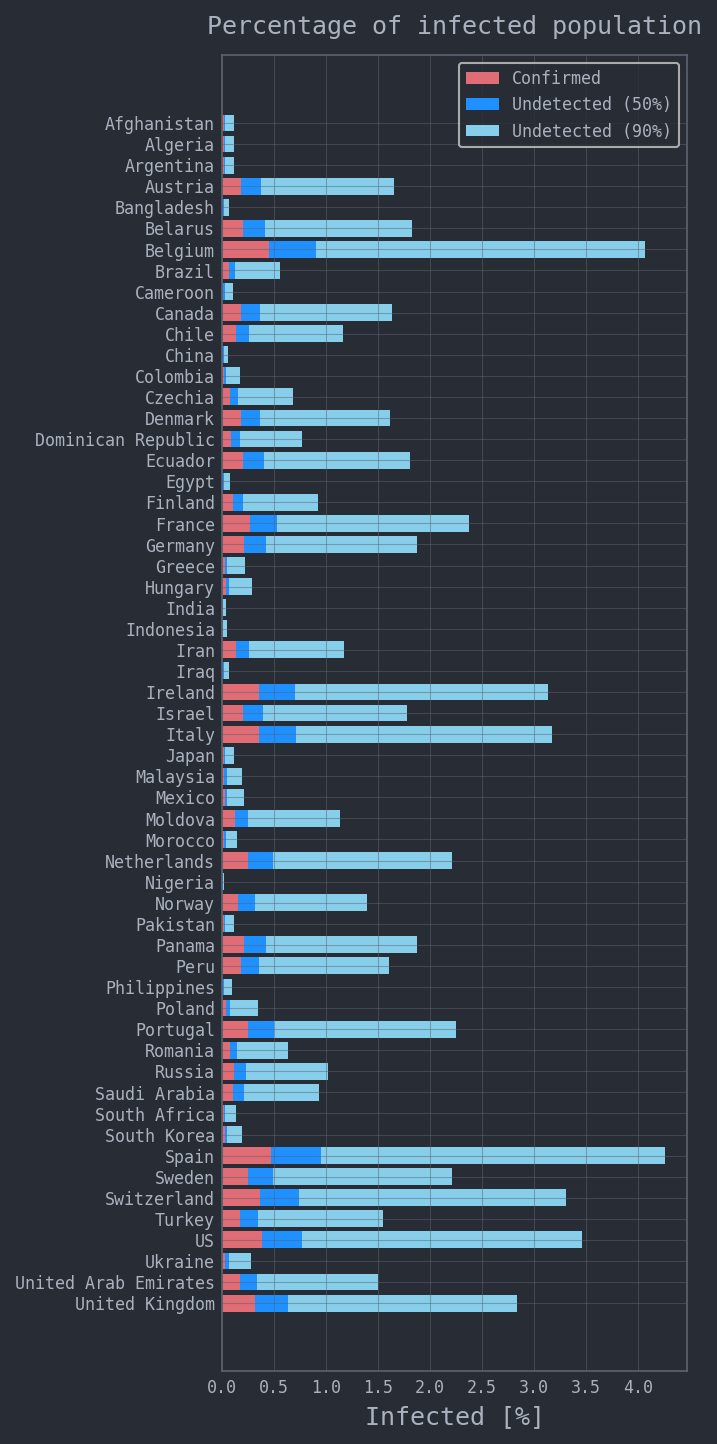

In [198]:
#hide
asymp = lambda factor: np.multiply(infected_population_list, factor)

height = len(countries)/5
fig, ax = plt.subplots(1, 1, figsize=(4, height), dpi=150)

# hack for disabling second plot 
axs = []
axs.append(ax)

# axs[1].barh(countries[::-1], deceased_population_list[::-1], color='gray', label='Deceased', alpha=0.8)
# axs[1].set_xlabel("Deceased [%]", fontsize=12)
# axs[1].tick_params(axis='both', which='major', labelsize=8)
# axs[1].set_yticklabels([])
# axs[1].yaxis.set_tick_params(width=1)


axs[0].barh(countries[::-1], infected_population_list[::-1], color='C0', label='Confirmed')
axs[0].barh(countries[::-1], asymp(2)[::-1], color='dodgerblue', label='Undetected (50%)', ls='--', lw=1,zorder=-2)
#axs[0].barh(countries[::-1], asymp(3)[::-1], left=infected_population_list[::-1], color='dodgerblue', label='Undetected (75%)', ls='--', alpha=0.6,lw=1)
axs[0].barh(countries[::-1], asymp(9)[::-1], color='skyblue', label='Undetected (90%)', ls='--', lw=1, zorder=-3)
axs[0].tick_params(axis='both', which='major', labelsize=8)
axs[0].yaxis.set_tick_params(width=1)


plt.title("Percentage of infected population", fontsize=12)
axs[0].set_xlabel("Infected [%]", fontsize=12)
max_value = np.max(asymp(3)[::-1]) + infected_population_list[::-1][np.argmax(asymp(3)[::-1])]
axs[0].legend(bbox_to_anchor=(1, 1.0), fontsize=8)

import matplotlib
bob = matplotlib.transforms.Bbox([[-0.45, height-3.8], [3.75, height-.8]])
plt.grid(alpha=0.5, lw=0.5)
plt.savefig("../images/icon_herd_immunity.png", bbox_inches=bob, pad_inches=0.0)

# Extrapolation

We can estimate the time it takes to reach a 60% infection of the population by extrapolating the already observed cases into the future. This estimation is model-free: we simply take the *30 day average* of the past confirmed new cases and assume that the infection rate (or rather the case confirmation rate) stays constant. Then, we can easily calculate how long it would take for each country to reach 60% of its population. 

As of 25.04.2020, this number for many, if not all, countries is absurdly high. This can be due to do with the fact the outbreak hasn't really started in most places yet since only a tiny amount of the population was infected or that testing capabilities are still very insufficient in many places. This number will change as the pandemic progresses and as we get a better estimation of the actual infection rate.

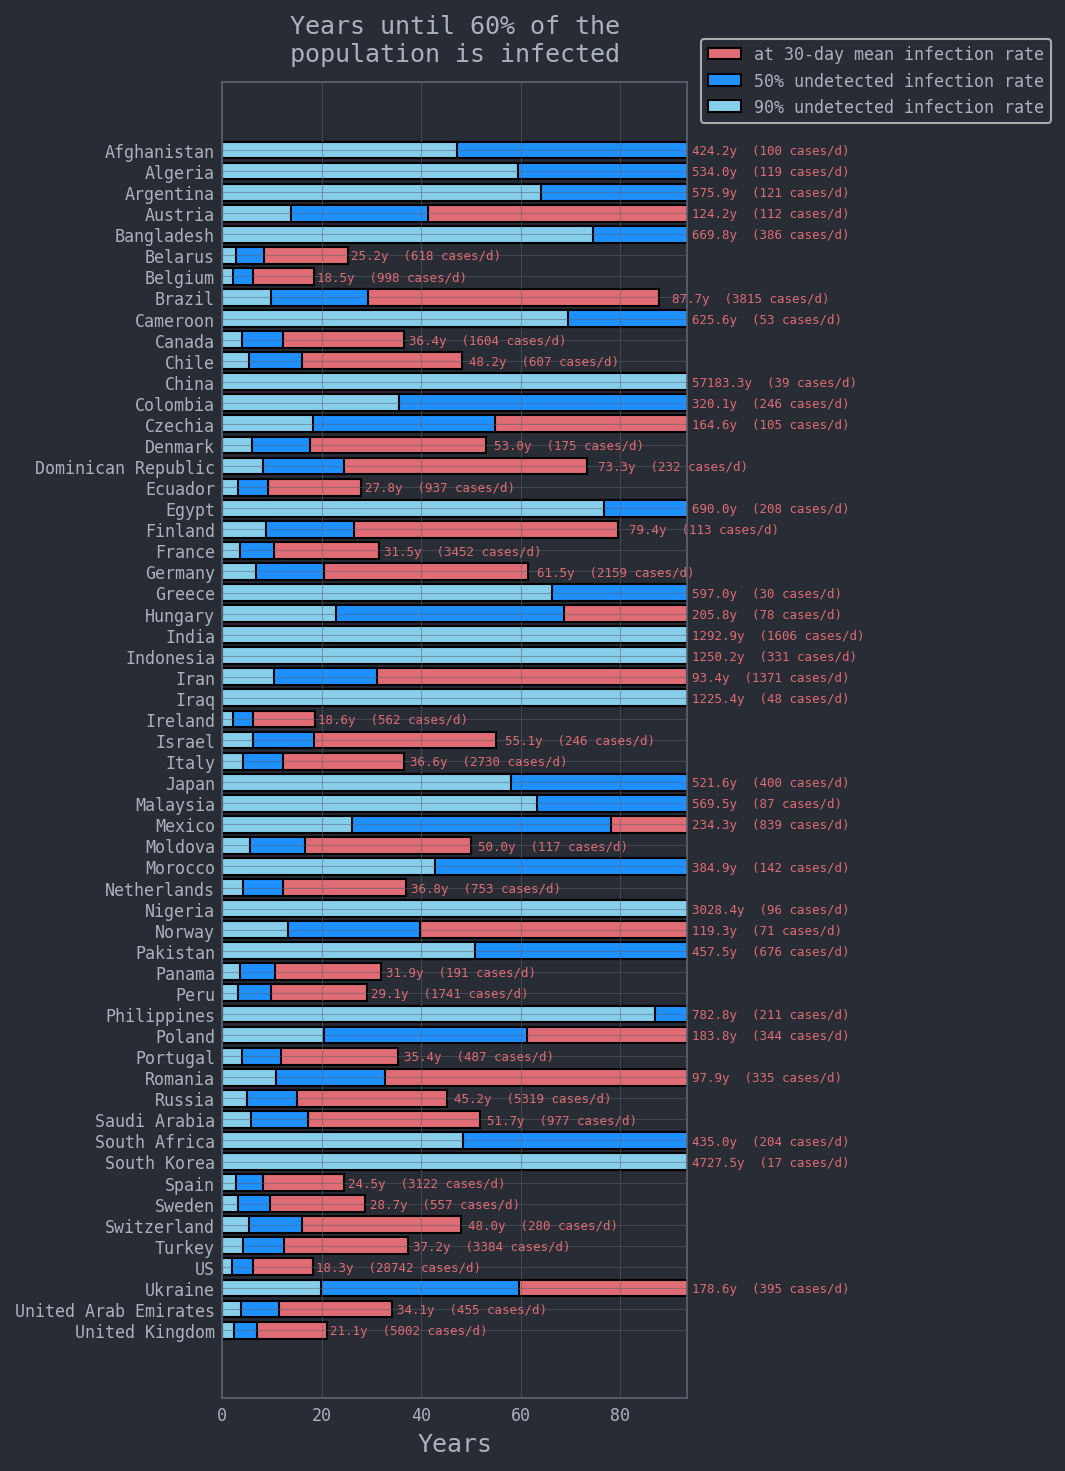

In [189]:
#hide
years_until_full_infection_list = np.divide(days_until_full_infection_list, 365)

height = len(countries)/5
fig, axs = plt.subplots(1, 1, figsize=(4, height), dpi=150)
plt.barh(countries[::-1], years_until_full_infection_list[::-1], color='C0',  edgecolor='k', label='at 30-day mean infection rate')


plt.barh(countries[::-1], np.divide(years_until_full_infection_list[::-1], 3), color='dodgerblue', edgecolor='k', label='50% undetected infection rate')
plt.barh(countries[::-1], np.divide(years_until_full_infection_list[::-1], 9), color='skyblue', edgecolor='k', label='90% undetected infection rate')



plt.tick_params(axis='both', which='major', labelsize=8)
plt.title(f"Years until {int(HERD_IMMUNITY_THRESHOLD*100)}% of the\npopulation is infected", fontsize=12)
plt.xlabel("Years", fontsize=12)

x_thresh = np.median(years_until_full_infection_list)
plt.xlim(0, x_thresh)

for i, c in enumerate(countries[::-1]):
    x_val = years_until_full_infection_list[::-1][i] 
    x_val *= 1.03
    if x_val > x_thresh:
        x_val = x_thresh*1.01
    txt = plt.text(x_val, i-0.2, f"{years_until_full_infection_list[::-1][i]:0.1f}y  ({int(new_cases_mean_list[::-1][i])} cases/d)", fontsize=6, fontweight='regular', color='C0')
plt.grid(alpha=0.5, lw=0.5)
plt.legend(bbox_to_anchor=(1.52,0.91), bbox_transform=plt.gcf().transFigure, fontsize=8)
plt.show();

In [190]:
#hide
def hide_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    

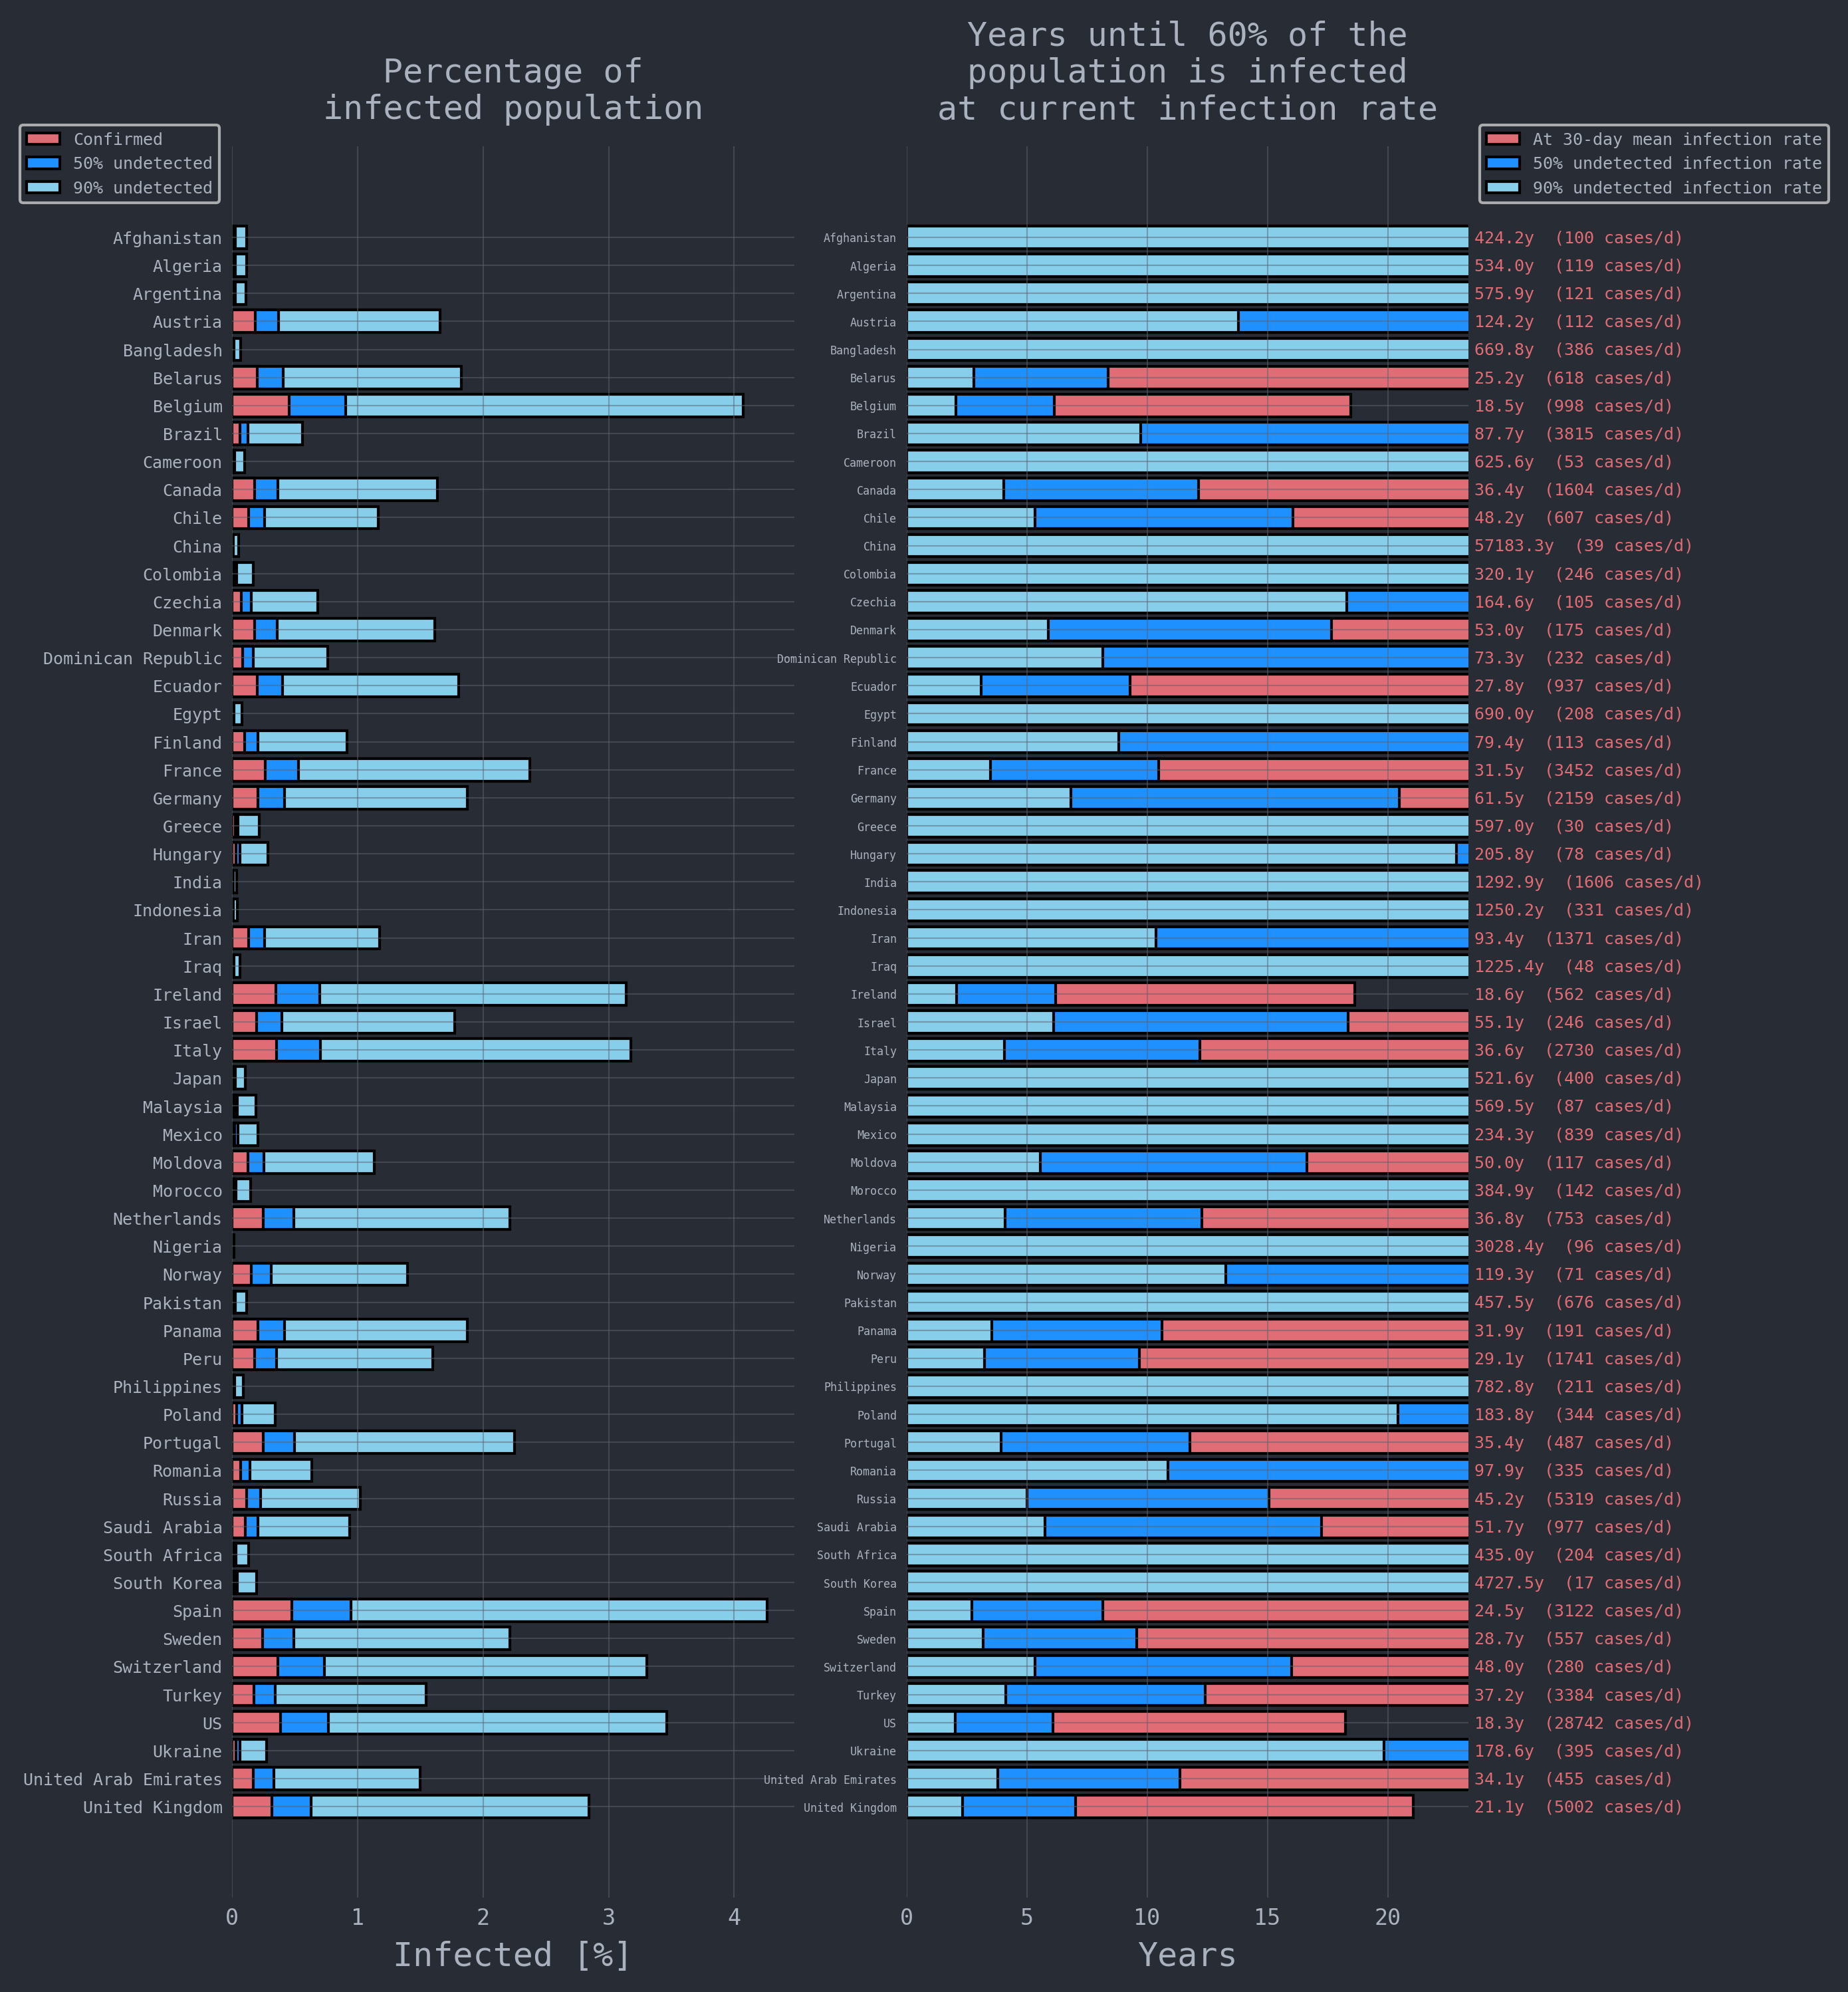

In [191]:
#hide_input
asymp = lambda factor: np.multiply(infected_population_list, factor)

height = len(countries)/5
fig, axs = plt.subplots(1, 2, figsize=(8, height), dpi=300)
axs[0].barh(countries[::-1], infected_population_list[::-1], color='C0', edgecolor='k',label='Confirmed')
axs[0].barh(countries[::-1], asymp(2)[::-1], color='dodgerblue', edgecolor='k',label='50% undetected', lw=1,zorder=-2)
#axs[0].barh(countries[::-1], asymp(3)[::-1], left=infected_population_list[::-1], color='dodgerblue', label='Undetected (75%)', ls='--', alpha=0.6,lw=1)
axs[0].barh(countries[::-1], asymp(9)[::-1], color='skyblue', edgecolor='k',label='90% undetected', lw=1, zorder=-3)

axs[0].tick_params(axis='y', which='major', labelsize=6)
axs[0].tick_params(axis='x', which='major', labelsize=8)
axs[0].yaxis.set_tick_params(width=1)


axs[0].set_title("Percentage of\ninfected population", fontsize=12)
axs[0].set_xlabel("Infected [%]", fontsize=12)
max_value = np.max(asymp(3)[::-1]) + infected_population_list[::-1][np.argmax(asymp(3)[::-1])]
#axs[0].legend(bbox_to_anchor=(1, 1.0), fontsize=8)
axs[0].legend(bbox_to_anchor=(-0.2,0.99), loc='center', bbox_transform=axs[0].transAxes, fontsize=6)


import matplotlib
bob = matplotlib.transforms.Bbox([[-0.7, height-3.8], [3.5, height-.8]])
axs[0].grid(alpha=0.5, lw=0.5)
#plt.savefig("../images/icon_herd_immunity.png", bbox_inches=bob, pad_inches=0.0)



years_until_full_infection_list = np.divide(days_until_full_infection_list, 365)
axs[1].barh(countries[::-1], years_until_full_infection_list[::-1], color='C0',  edgecolor='k', label='At 30-day mean infection rate')
axs[1].barh(countries[::-1], np.divide(years_until_full_infection_list[::-1], 3), color='dodgerblue', edgecolor='k', label='50% undetected infection rate')
plt.barh(countries[::-1], np.divide(years_until_full_infection_list[::-1], 9), color='skyblue', edgecolor='k', label='90% undetected infection rate')


axs[1].tick_params(axis='y', which='major', labelsize=4)
axs[1].tick_params(axis='x', which='major', labelsize=8)

axs[1].set_title(f"Years until {int(HERD_IMMUNITY_THRESHOLD*100)}% of the\npopulation is infected\nat current infection rate", fontsize=12)
axs[1].set_xlabel("Years", fontsize=12)

x_thresh = np.median(years_until_full_infection_list) / 4
axs[1].set_xlim(0, x_thresh)

for i, c in enumerate(countries[::-1]):
    x_val = years_until_full_infection_list[::-1][i] 
    x_val *= 1.03
    if x_val > x_thresh:
        x_val = x_thresh*1.01
    # delete this line for dynamic spacing
    x_val = x_thresh*1.01
    txt = plt.text(x_val, i-0.2, f"{years_until_full_infection_list[::-1][i]:0.1f}y  ({int(new_cases_mean_list[::-1][i])} cases/d)", fontsize=6, fontweight='regular', color='C0')
axs[1].grid(alpha=0.5, lw=0.5)
axs[1].legend(bbox_to_anchor=(1.33,0.99), loc='center', bbox_transform=axs[1].transAxes, fontsize=6)
hide_axis(axs[0])
hide_axis(axs[1])
plt.show();

## Baseline measurements

Here we show the case rate for each country and highlight the last 30 days of confirmed cases that were used as a baseline to project the case rate into the future.

Afghanistan


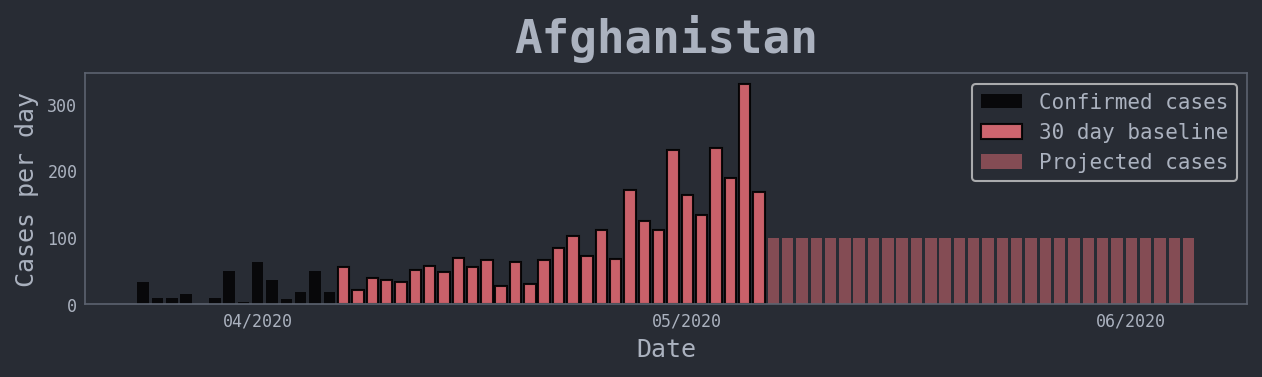

Algeria


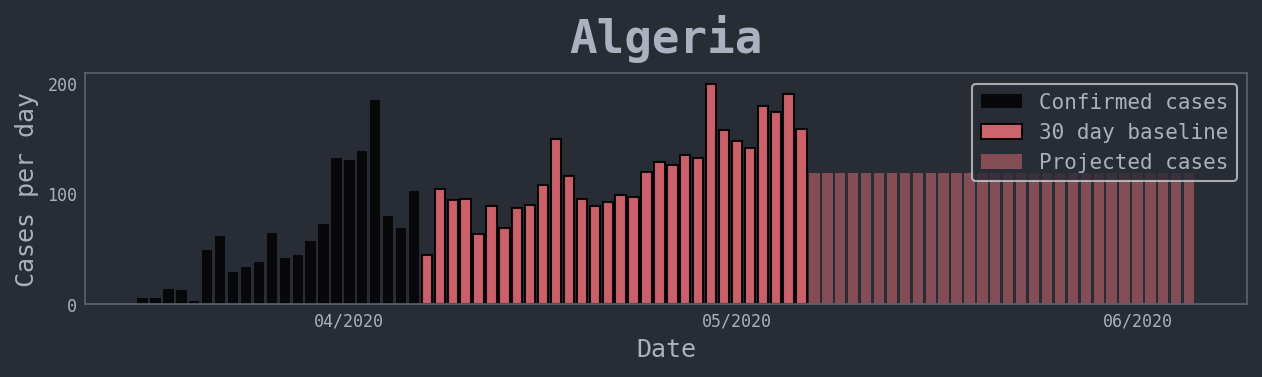

Argentina


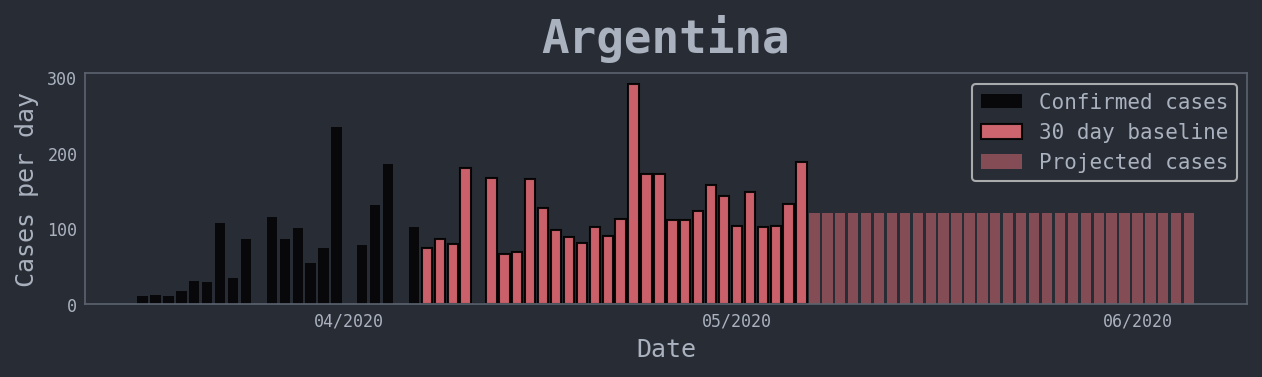

Austria


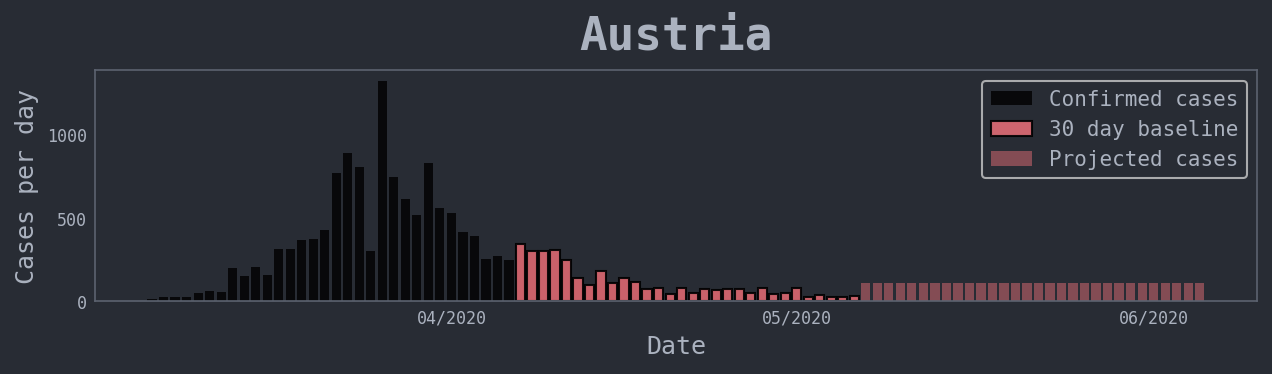

Bangladesh


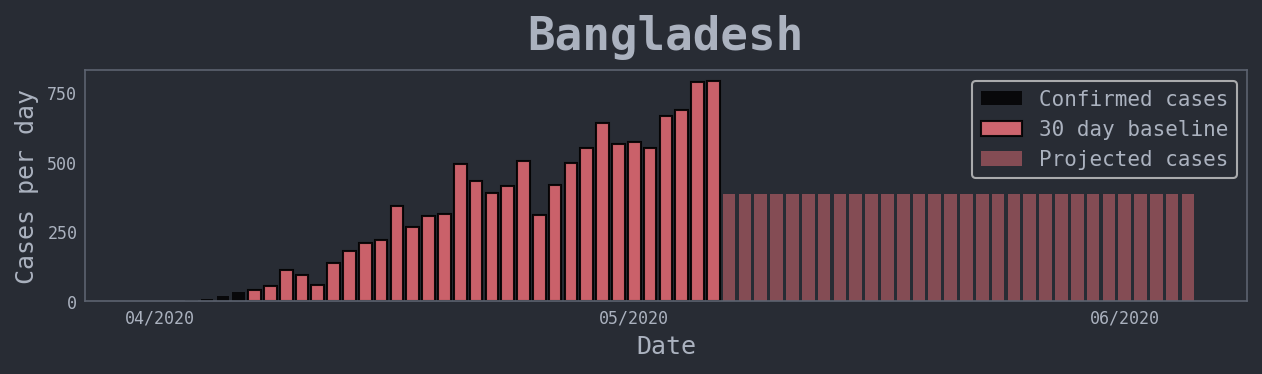

Belarus


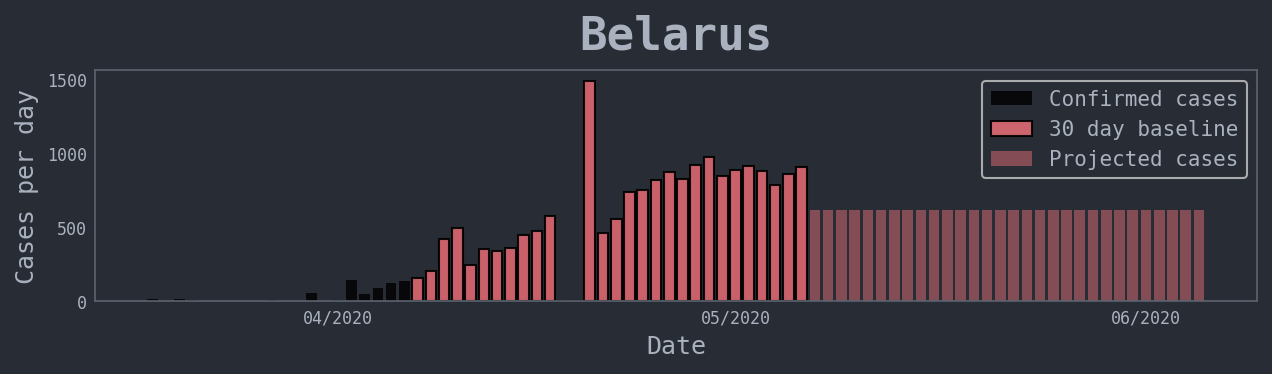

Belgium


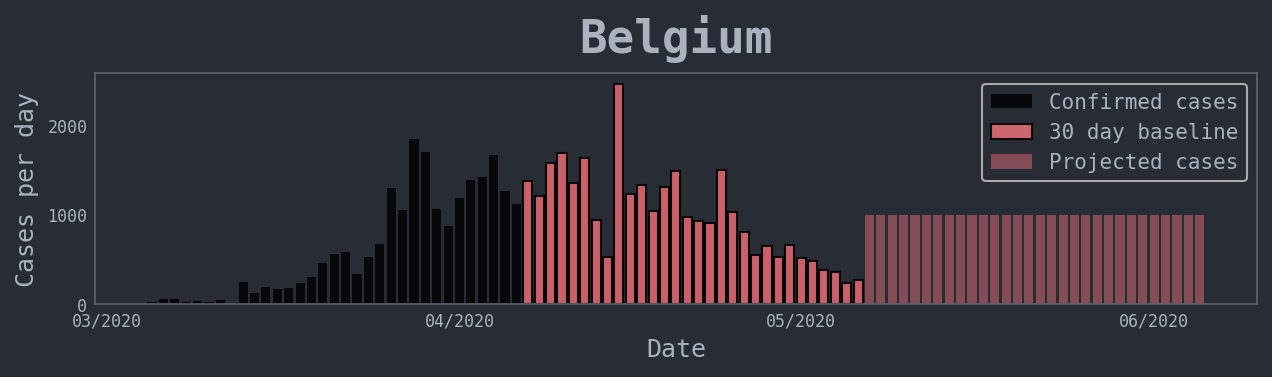

Brazil


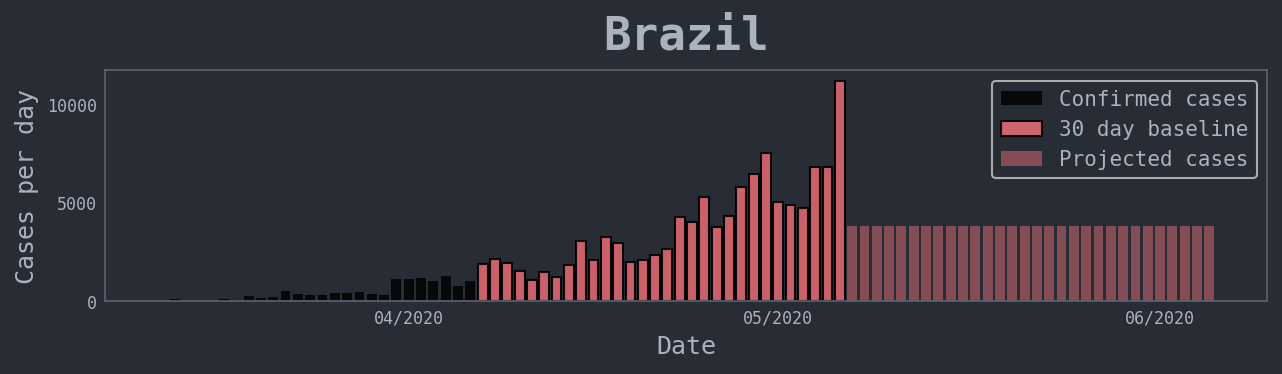

Cameroon


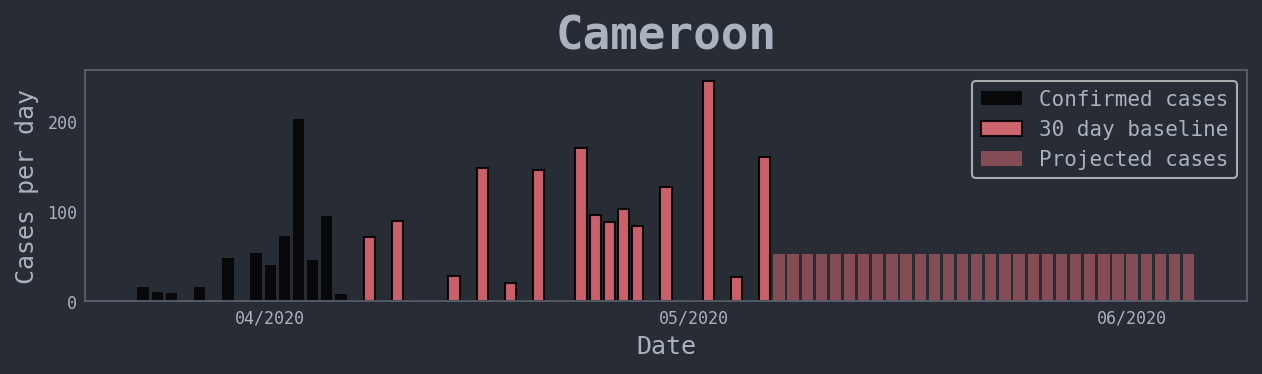

Canada


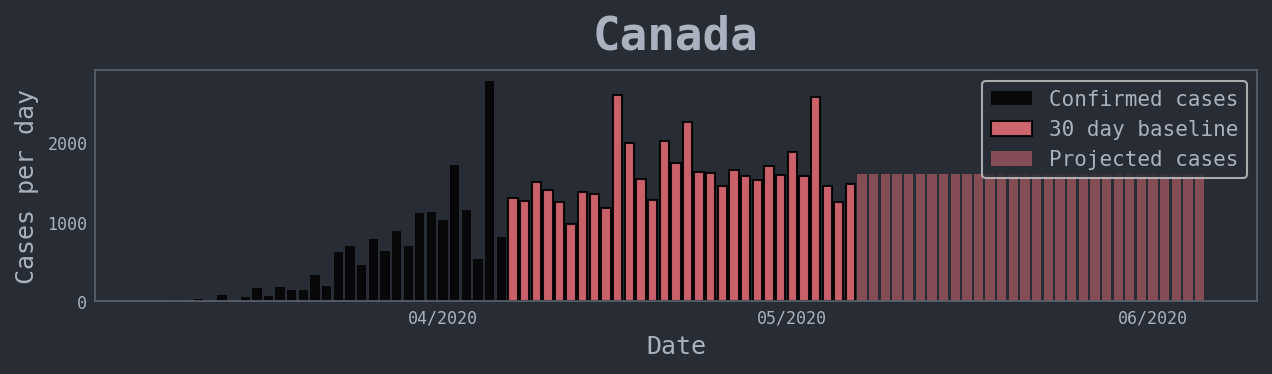

Chile


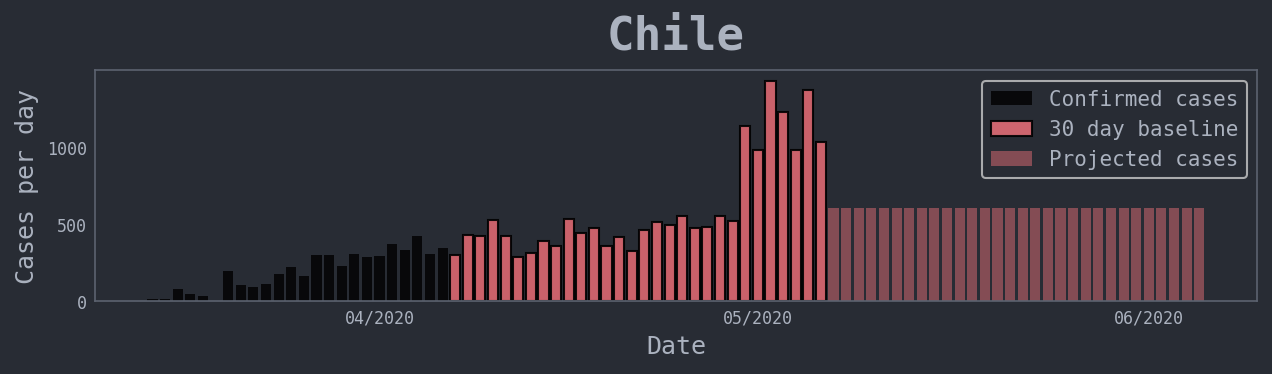

China


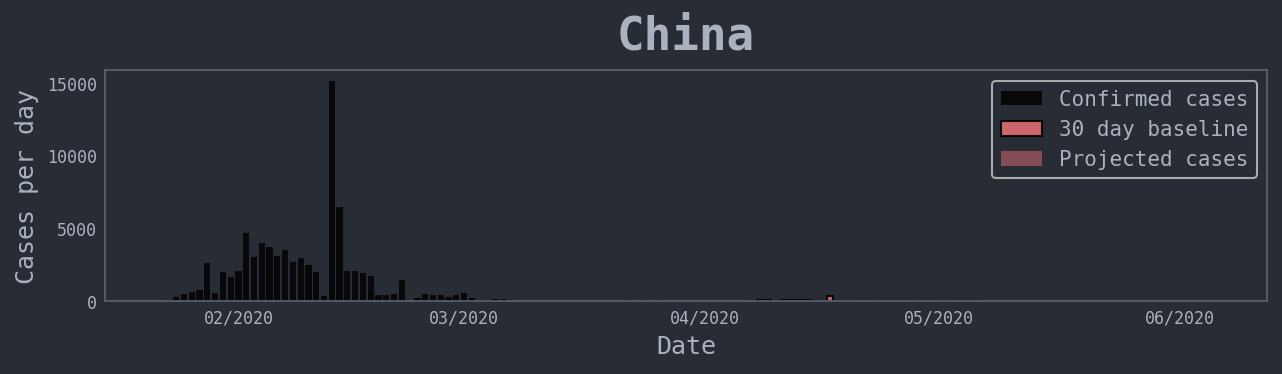

Colombia


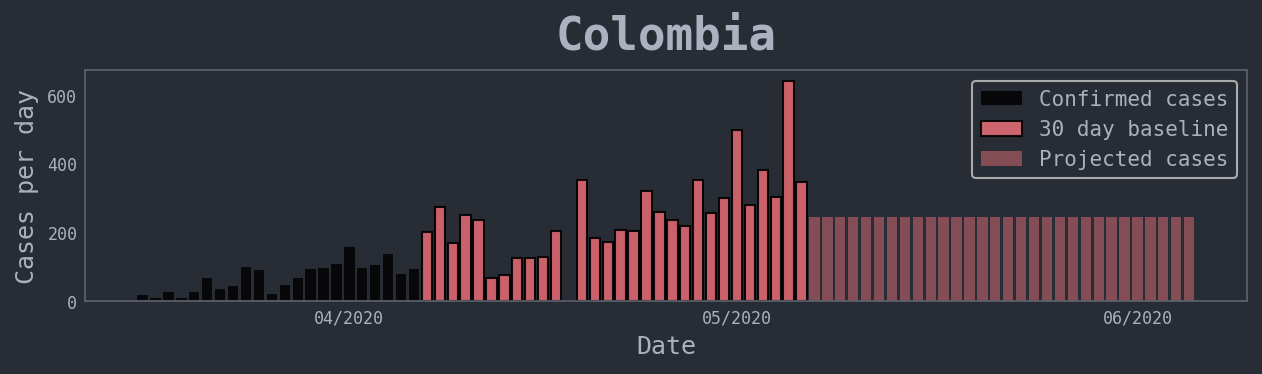

Czechia


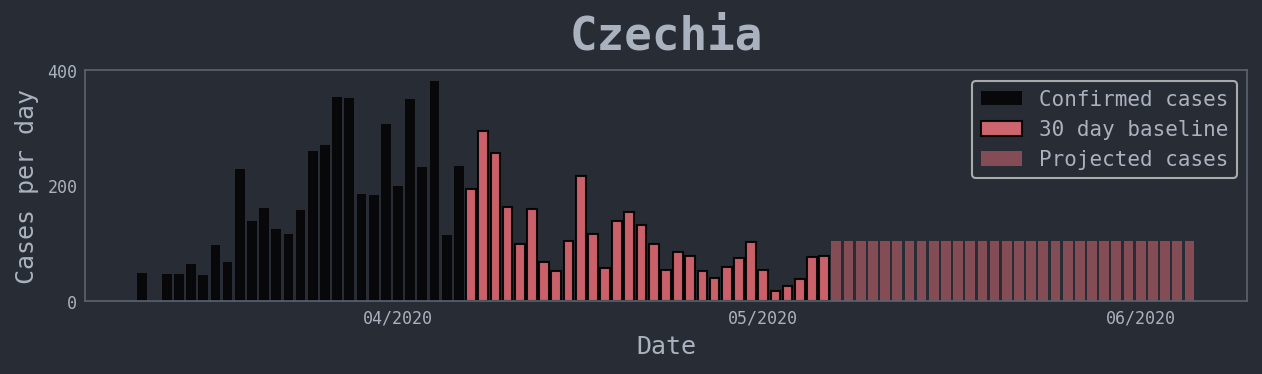

Denmark


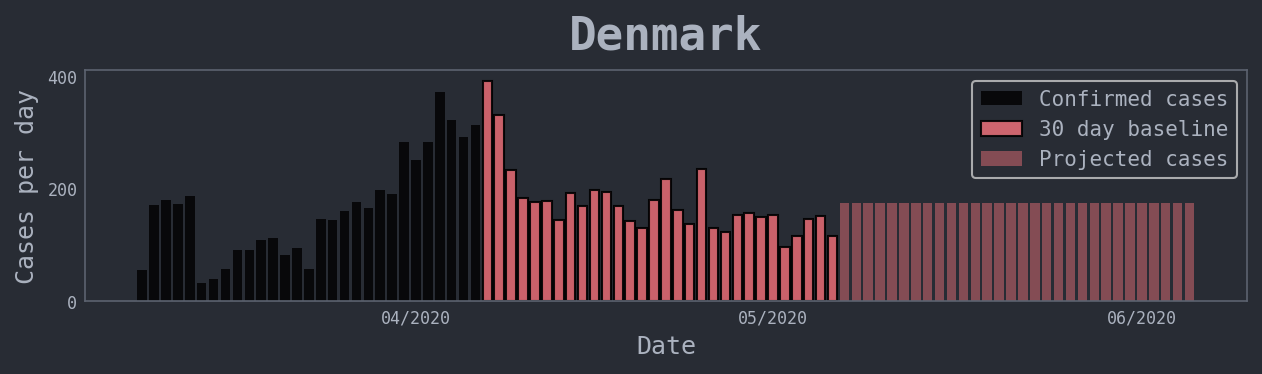

Dominican Republic


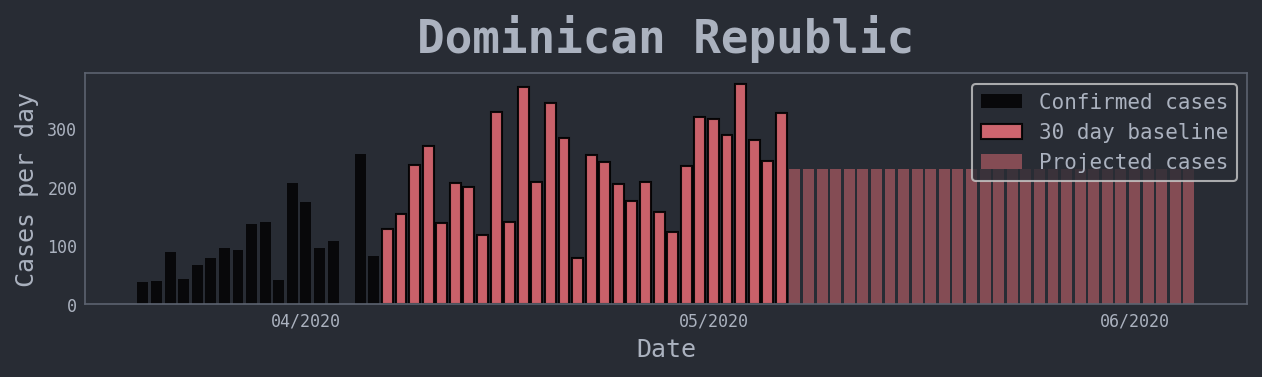

Ecuador


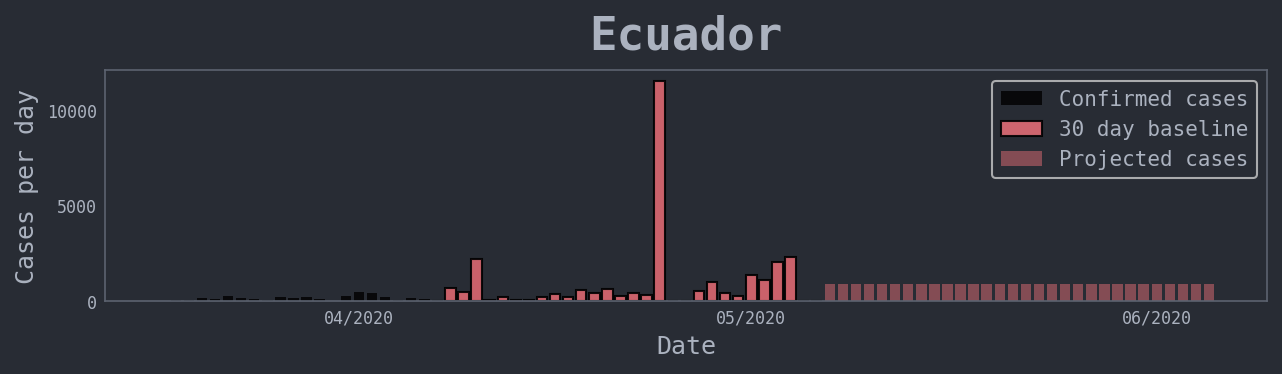

Egypt


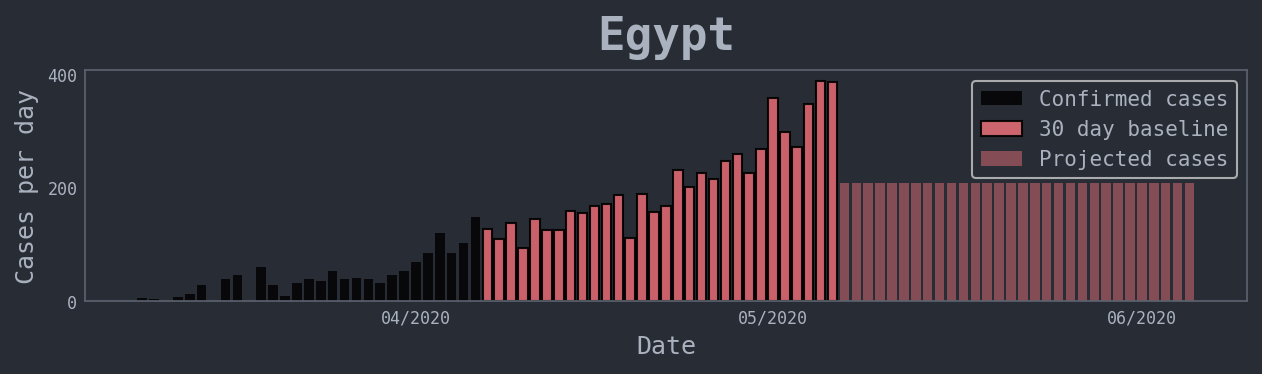

Finland


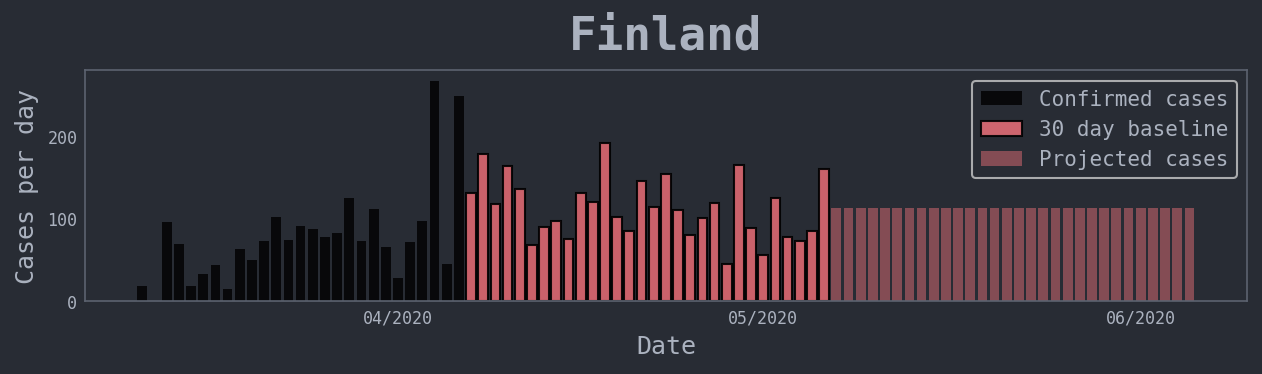

France


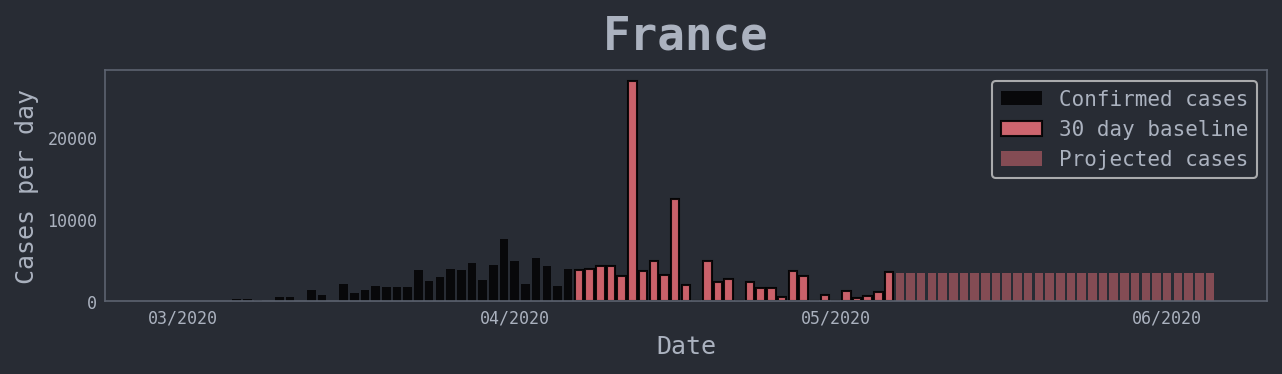

Germany


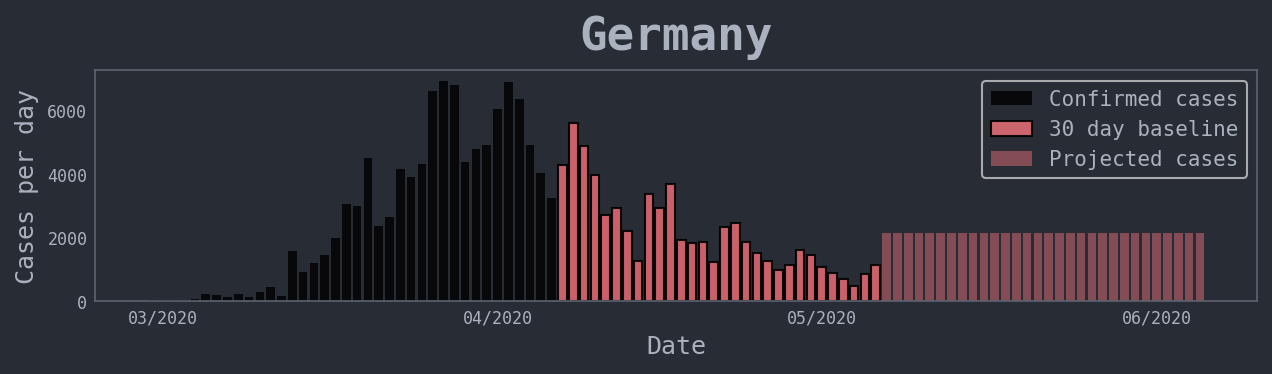

Greece


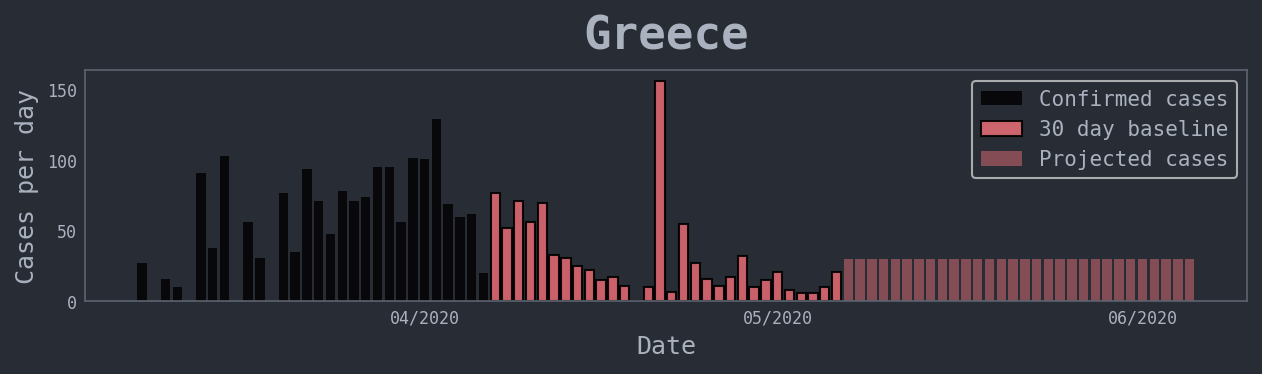

Hungary


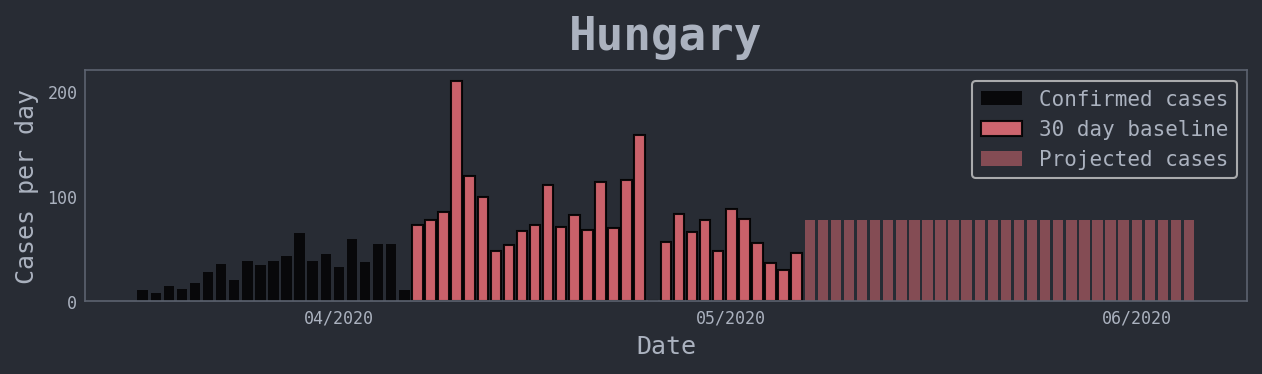

India


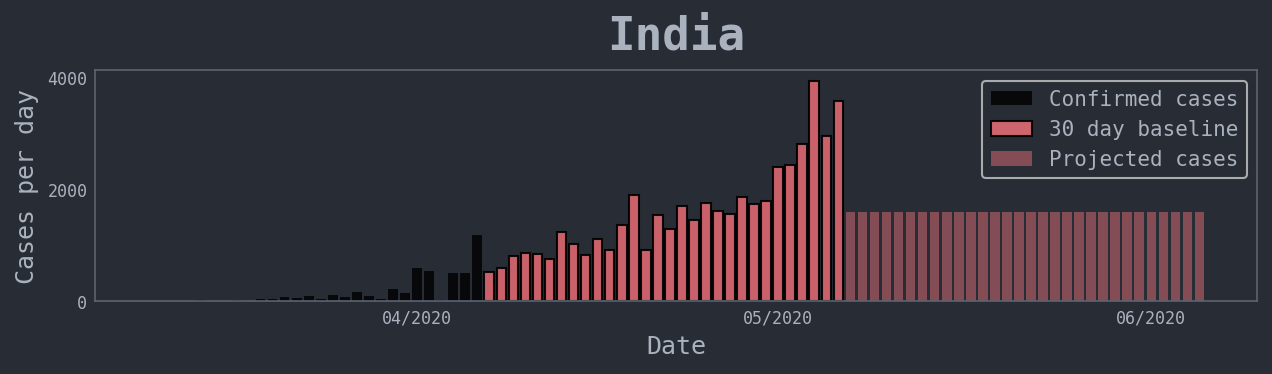

Indonesia


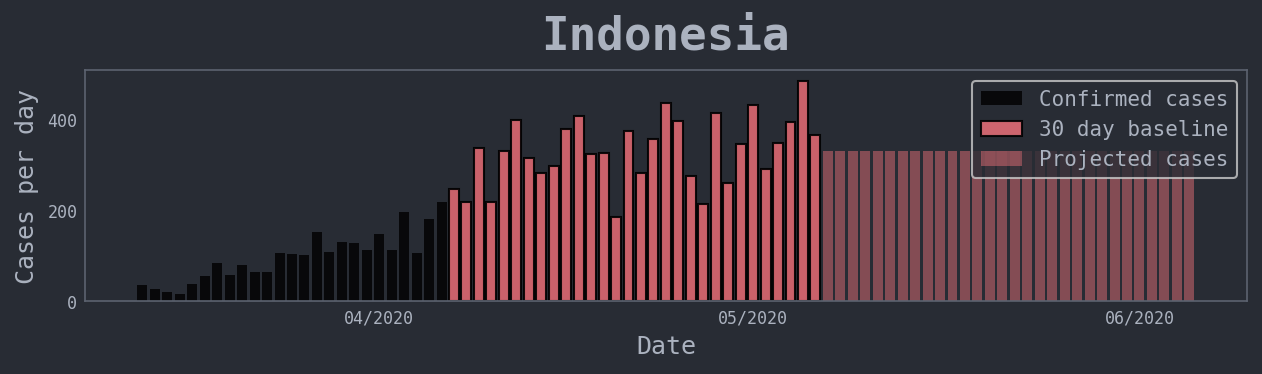

Iran


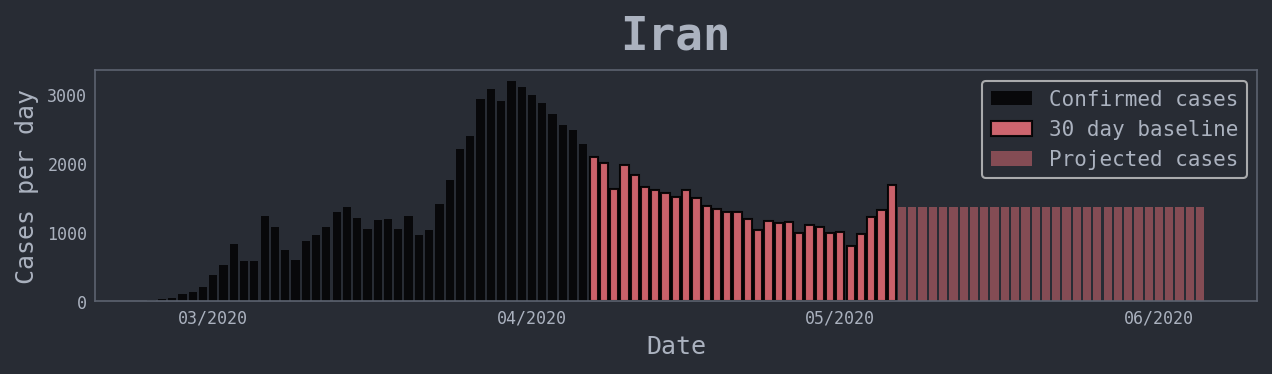

Iraq


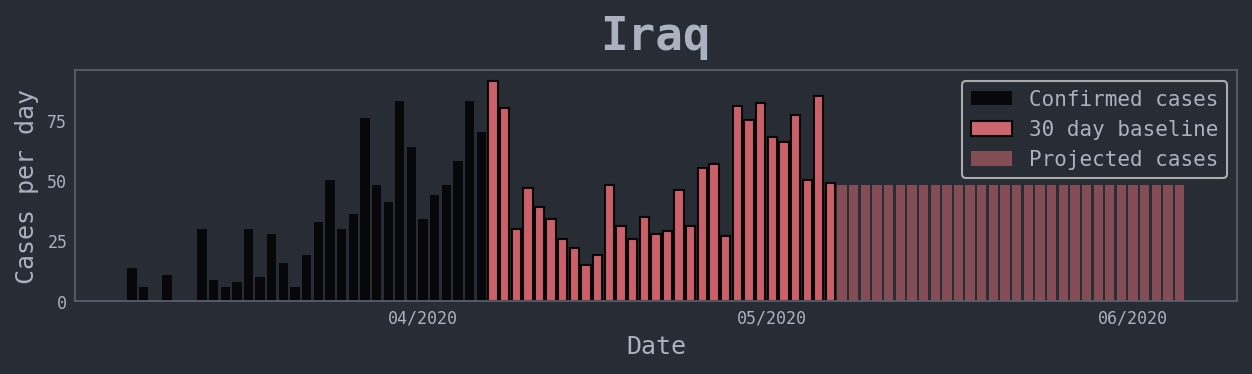

Ireland


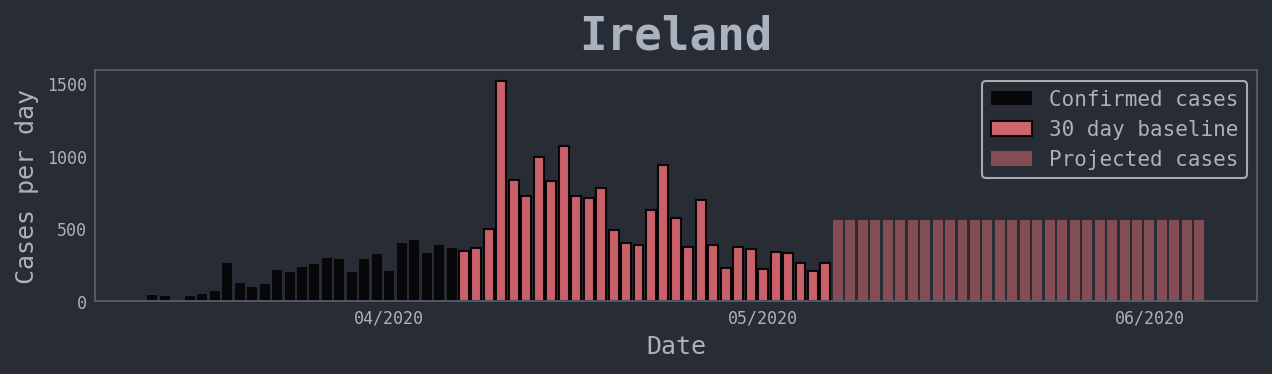

Israel


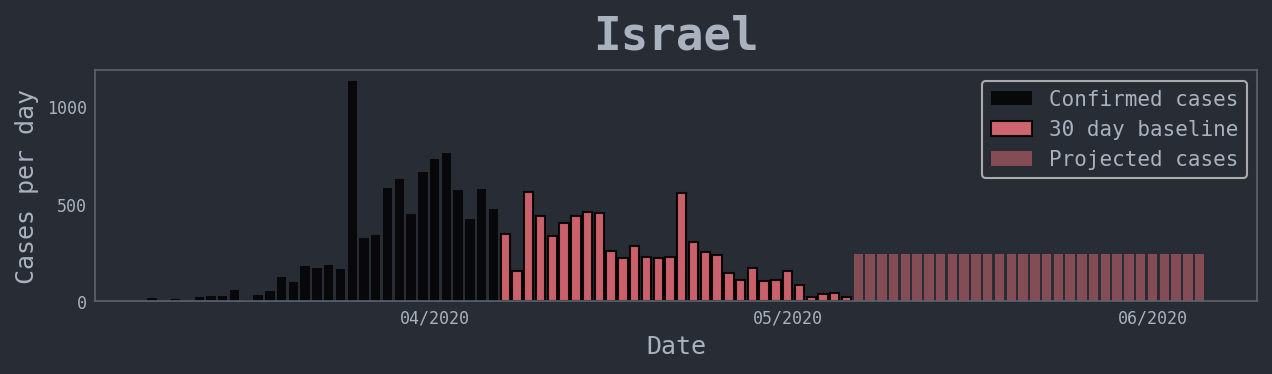

Italy


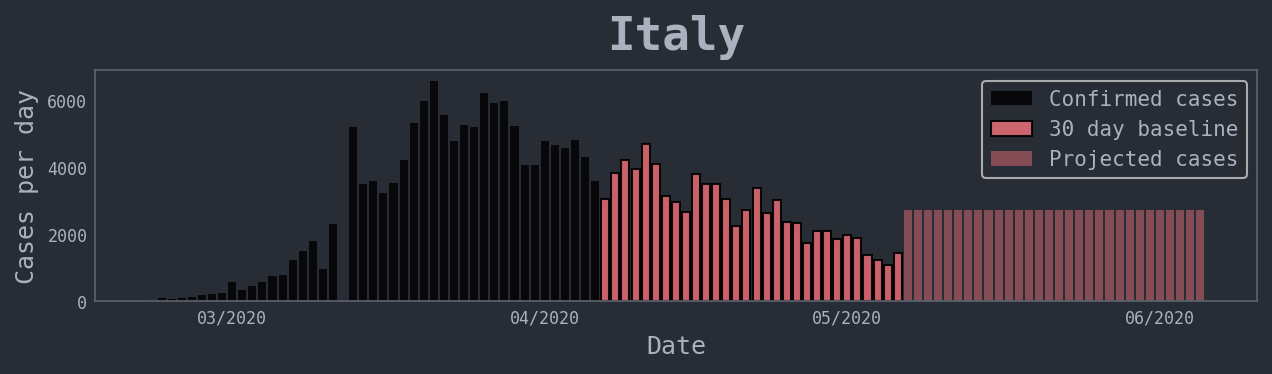

Japan


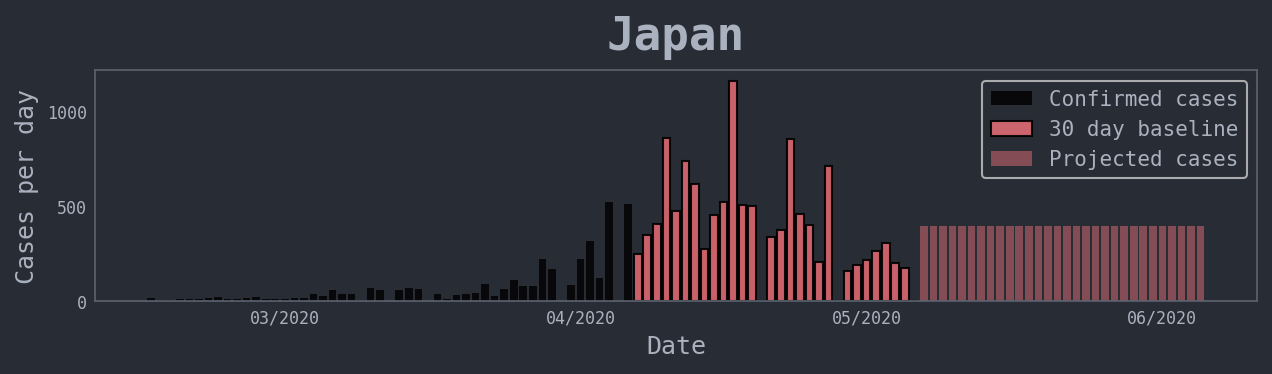

Malaysia


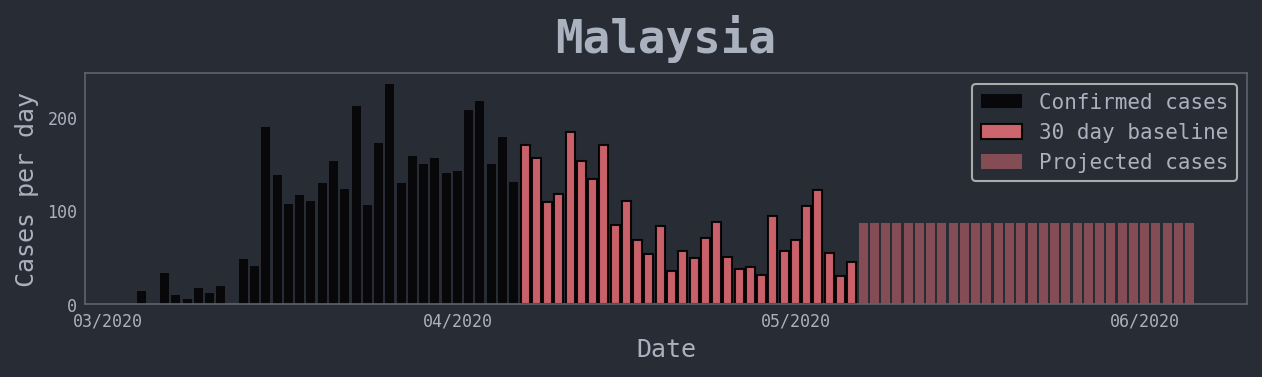

Mexico


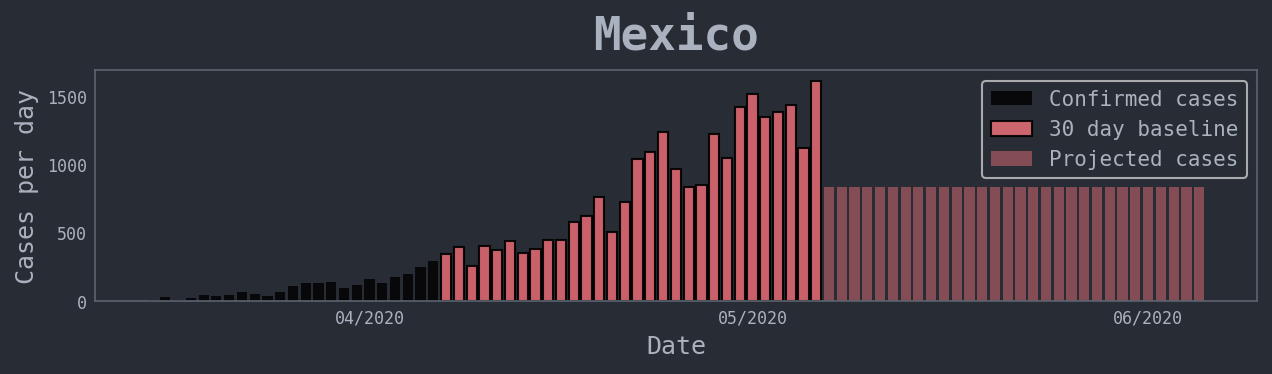

Moldova


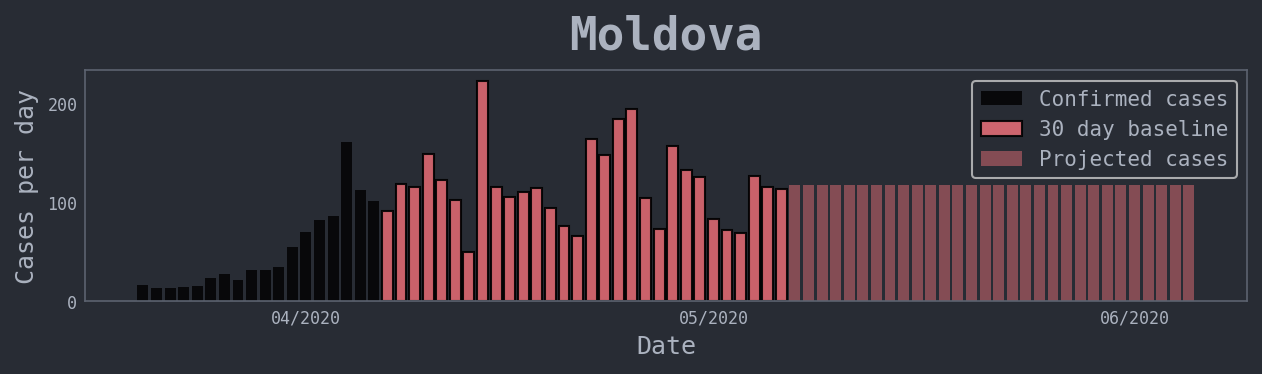

Morocco


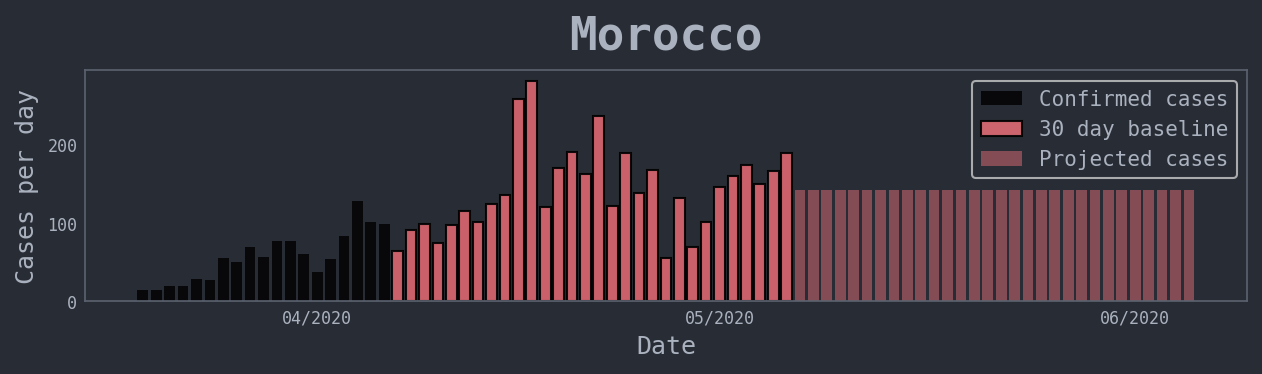

Netherlands


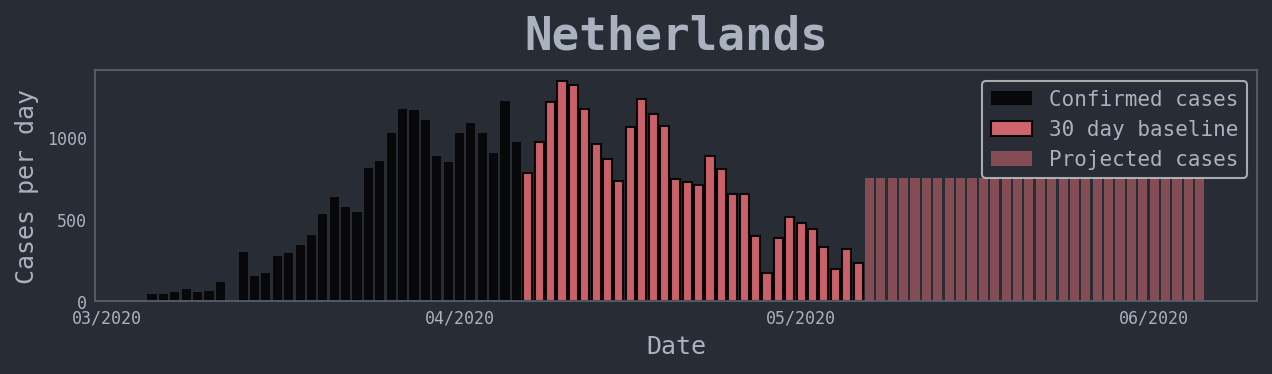

Nigeria


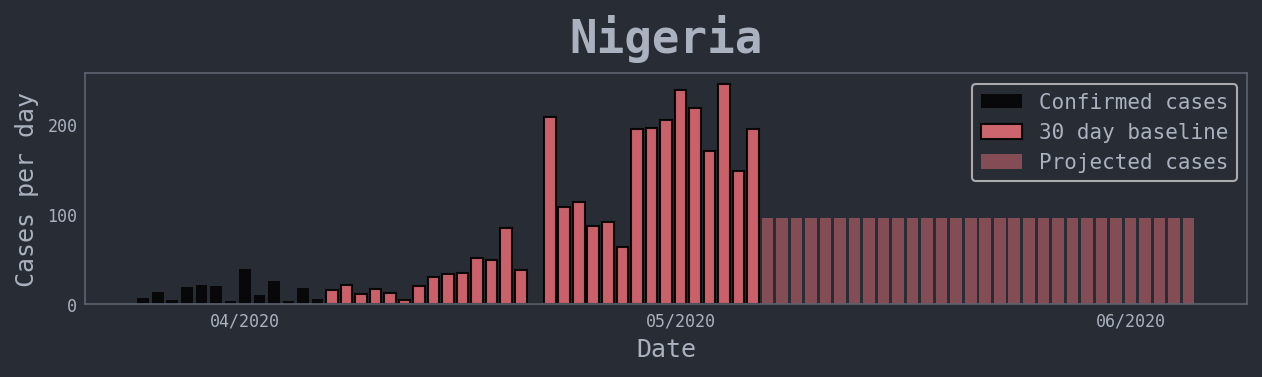

Norway


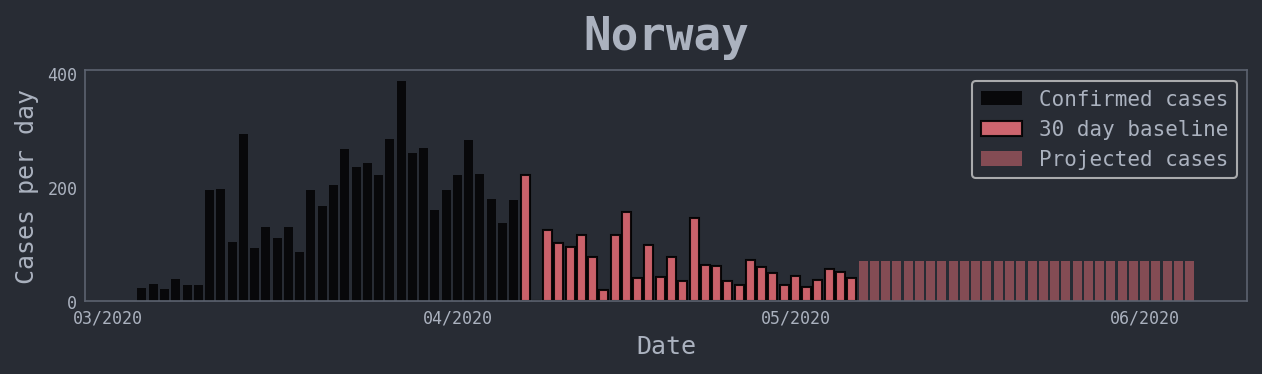

Pakistan


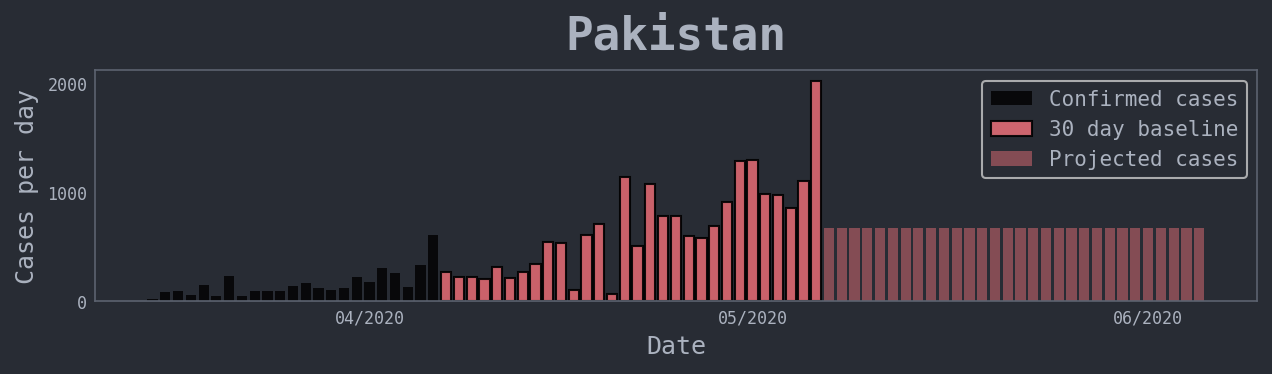

Panama


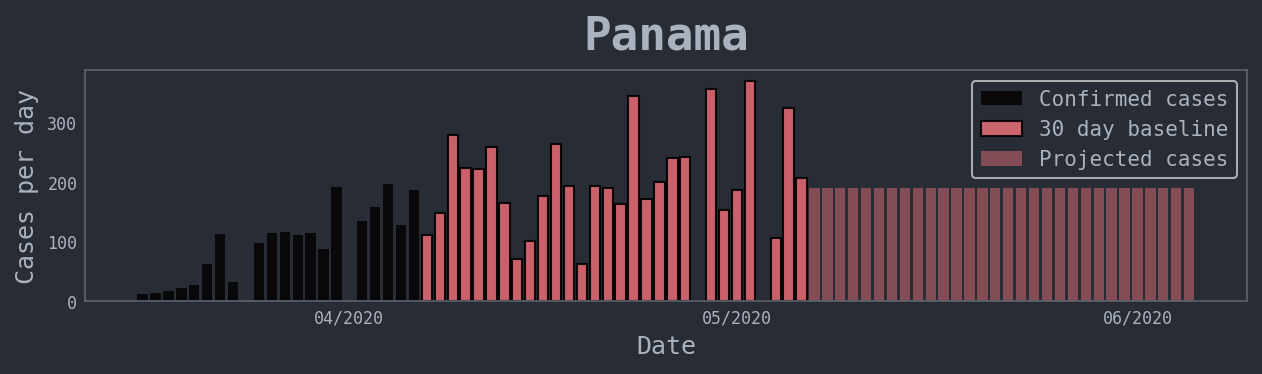

Peru


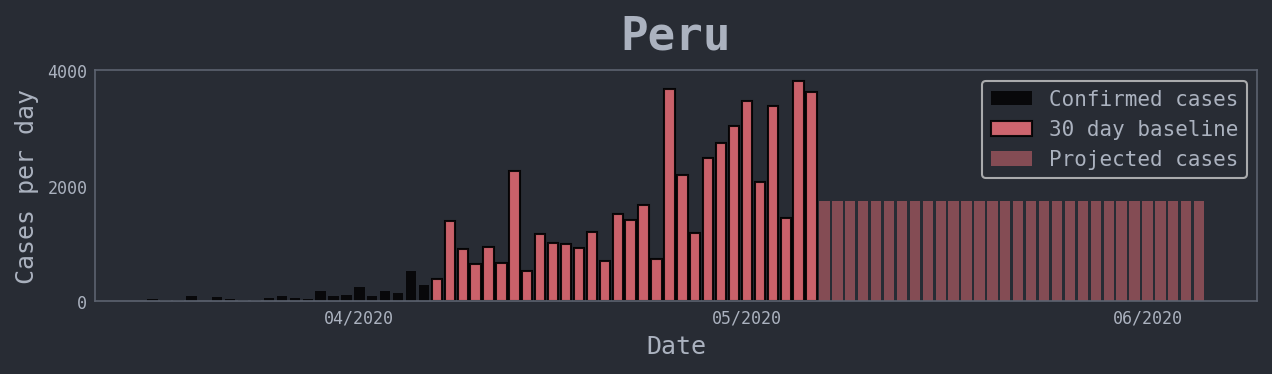

Philippines


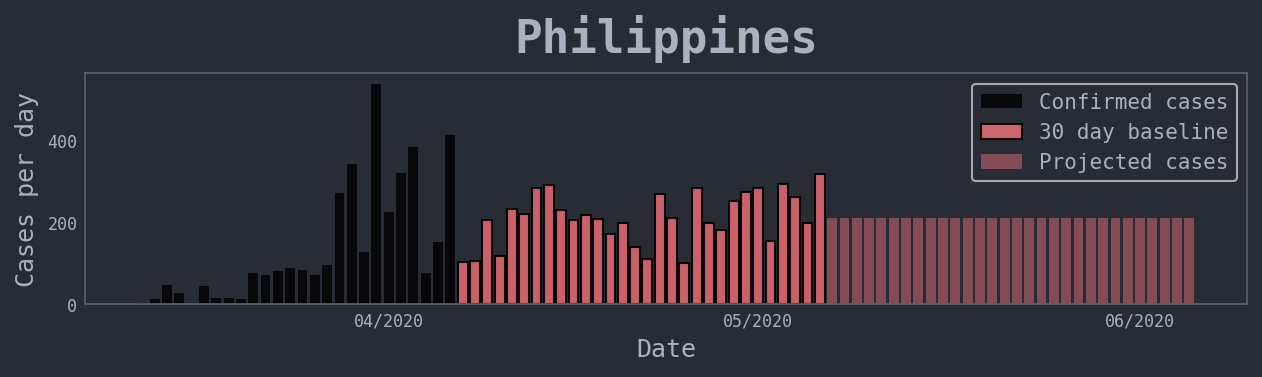

Poland


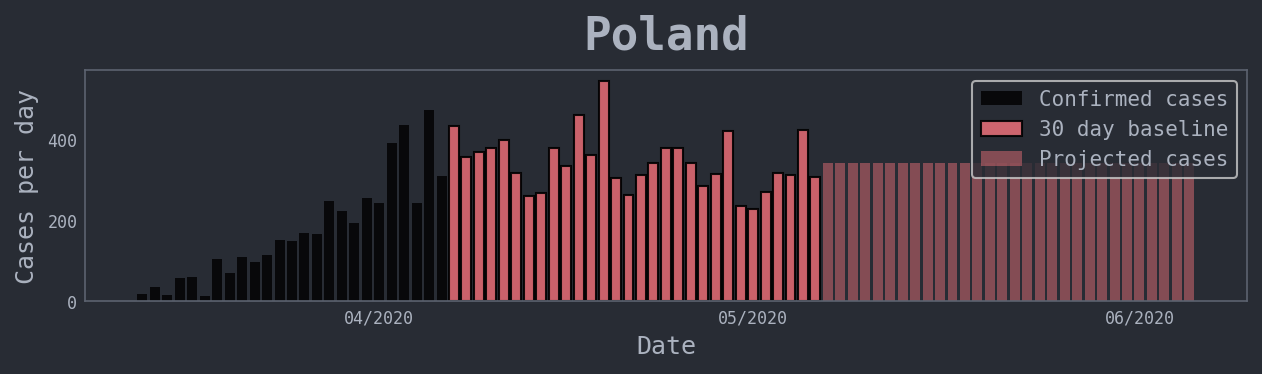

Portugal


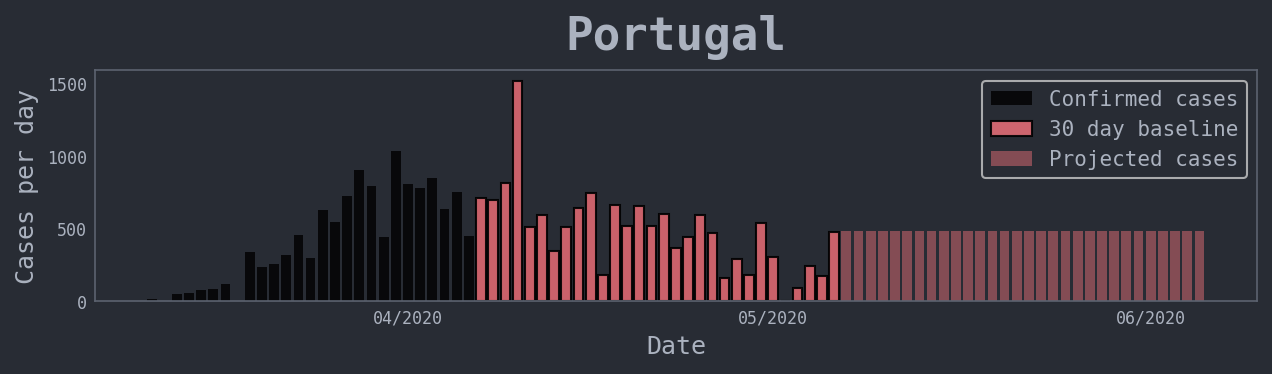

Romania


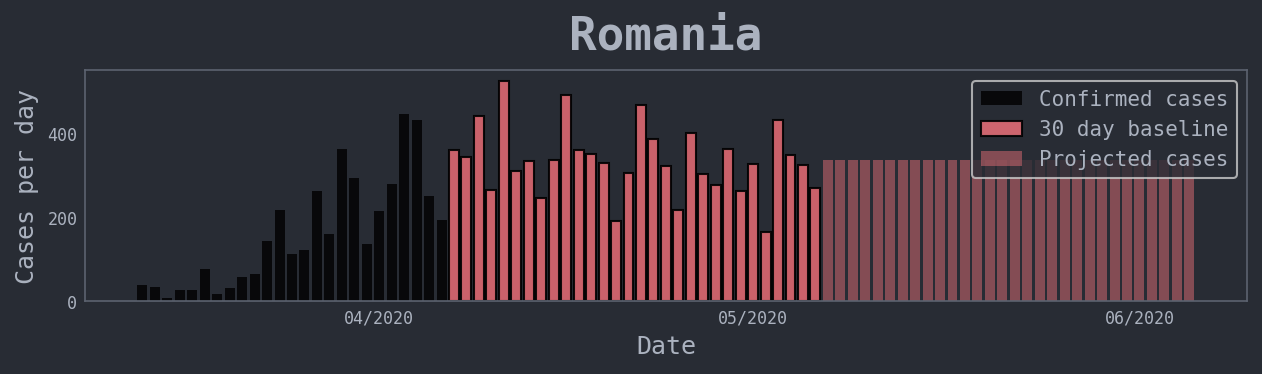

Russia


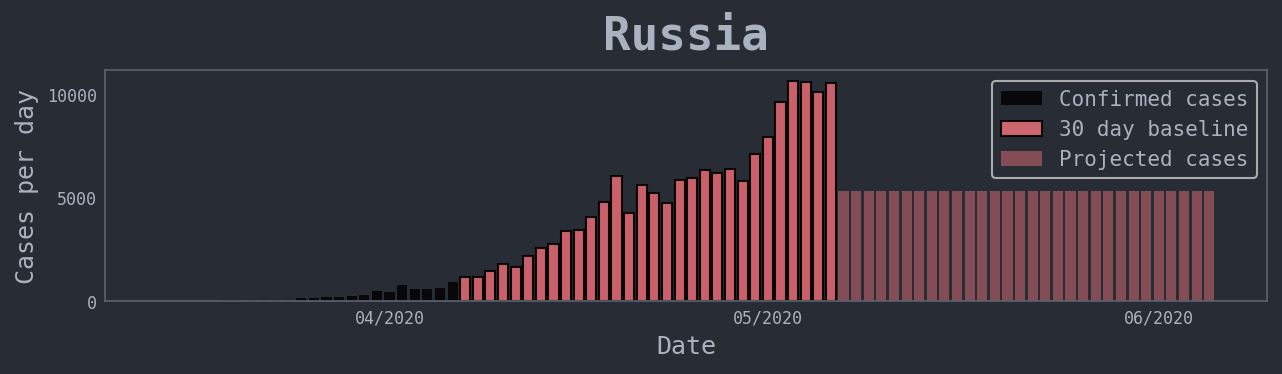

Saudi Arabia


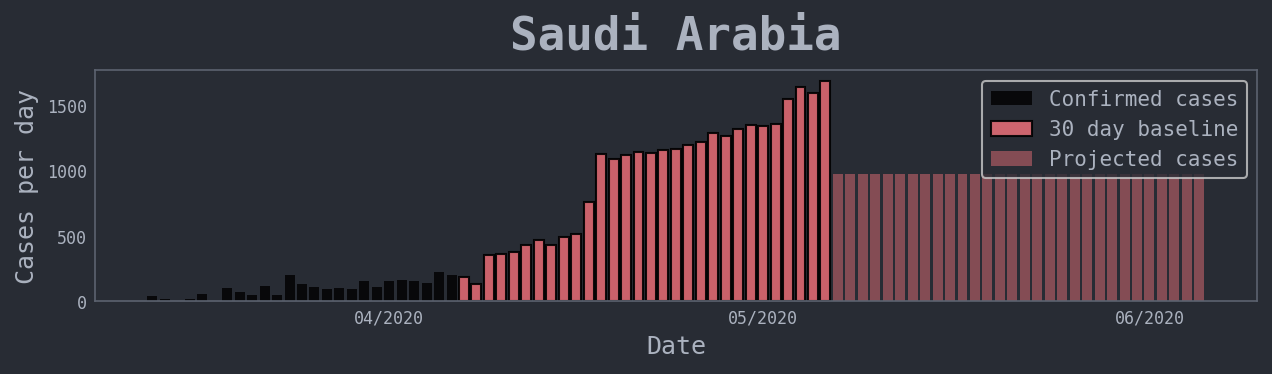

South Africa


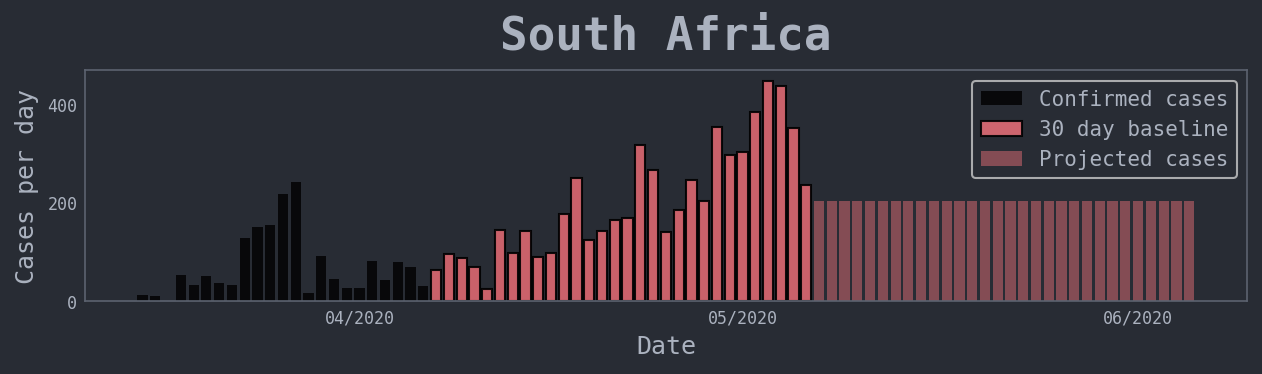

South Korea


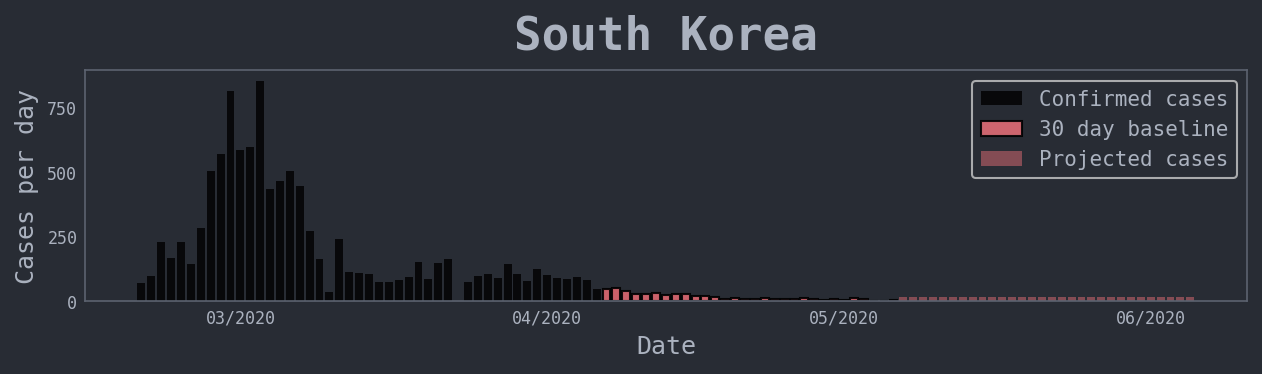

Spain


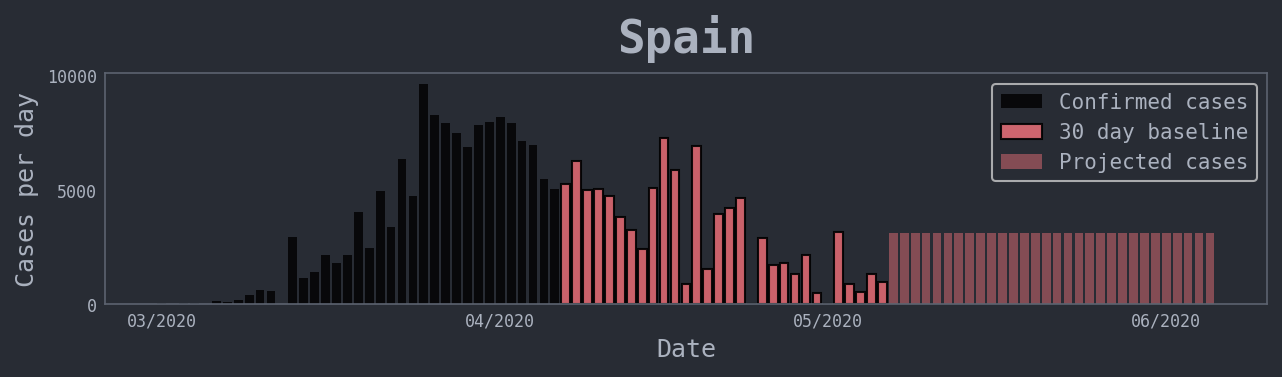

Sweden


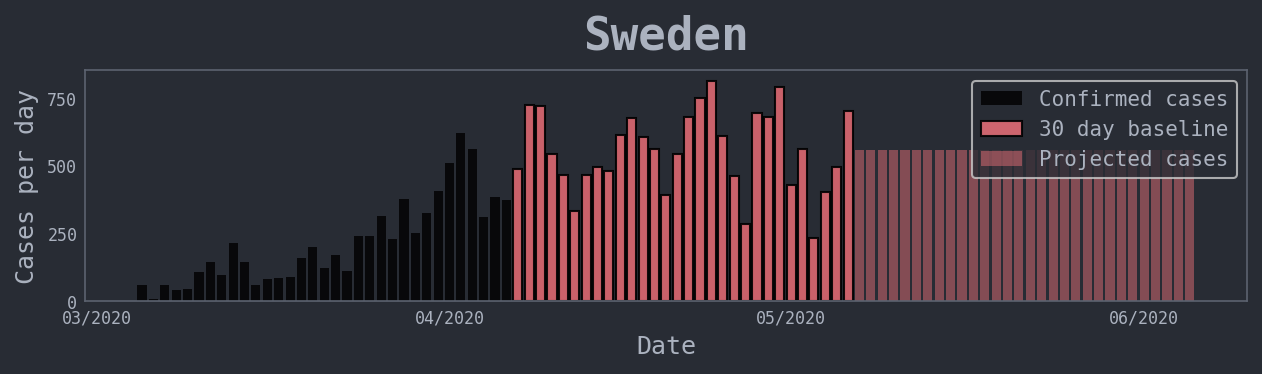

Switzerland


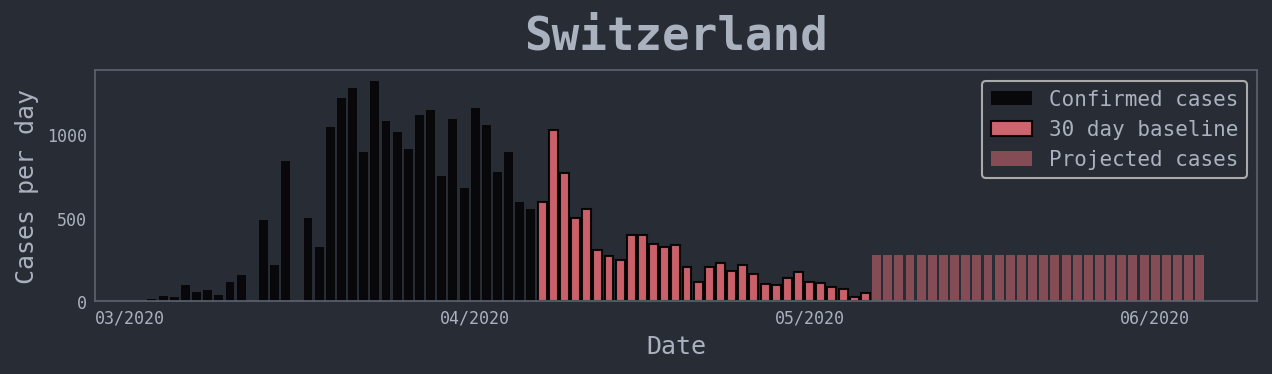

Turkey


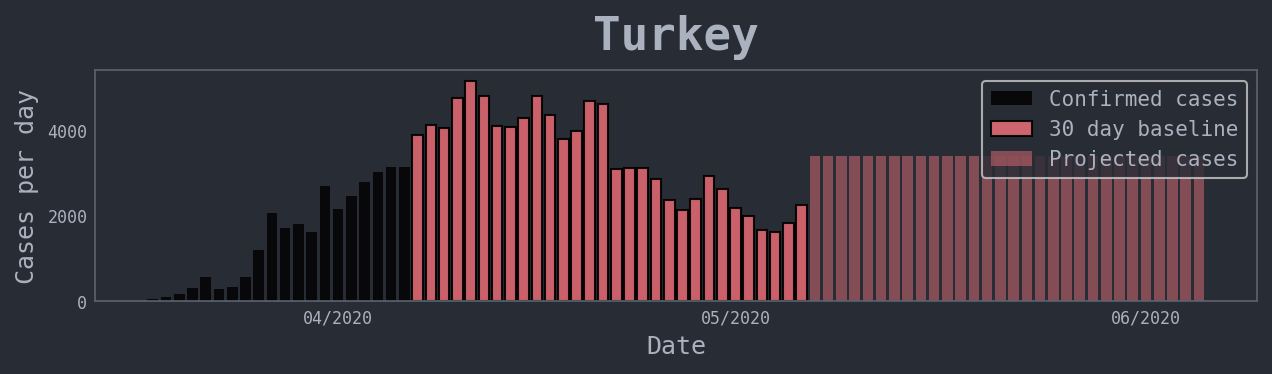

US


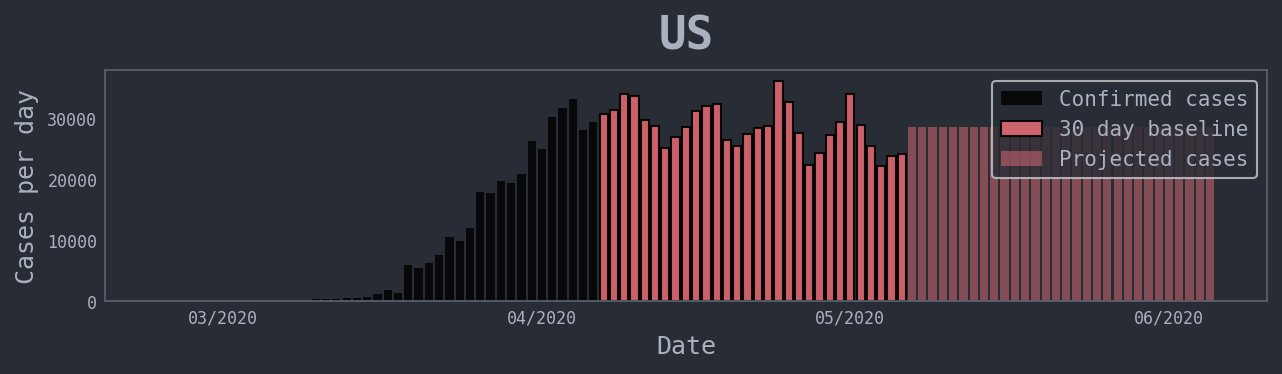

Ukraine


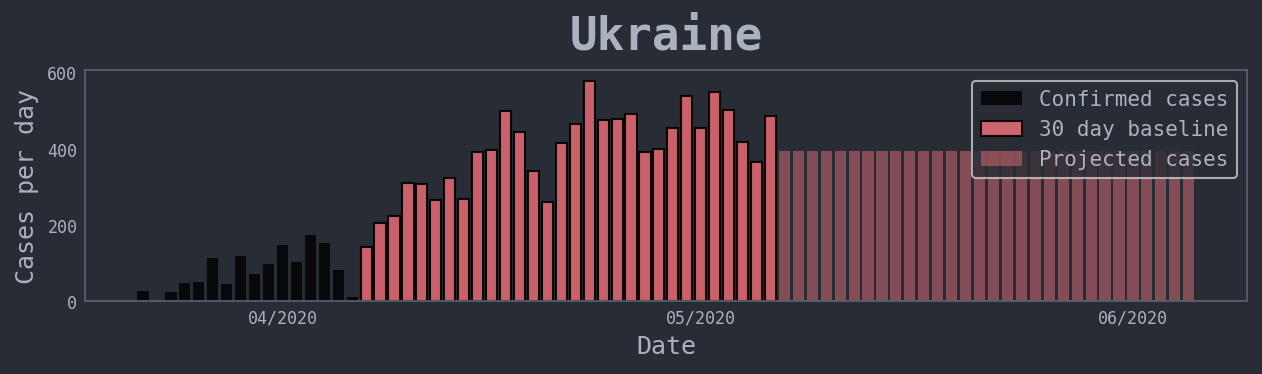

United Arab Emirates


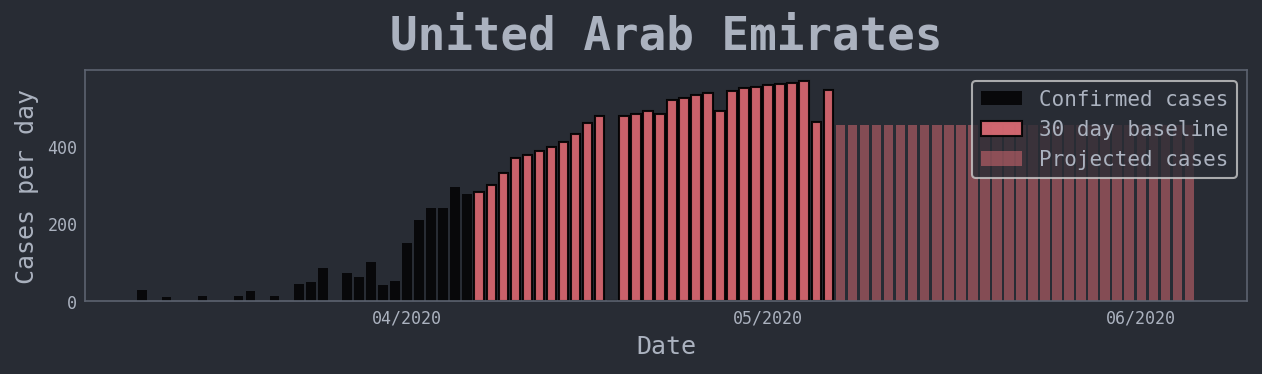

United Kingdom


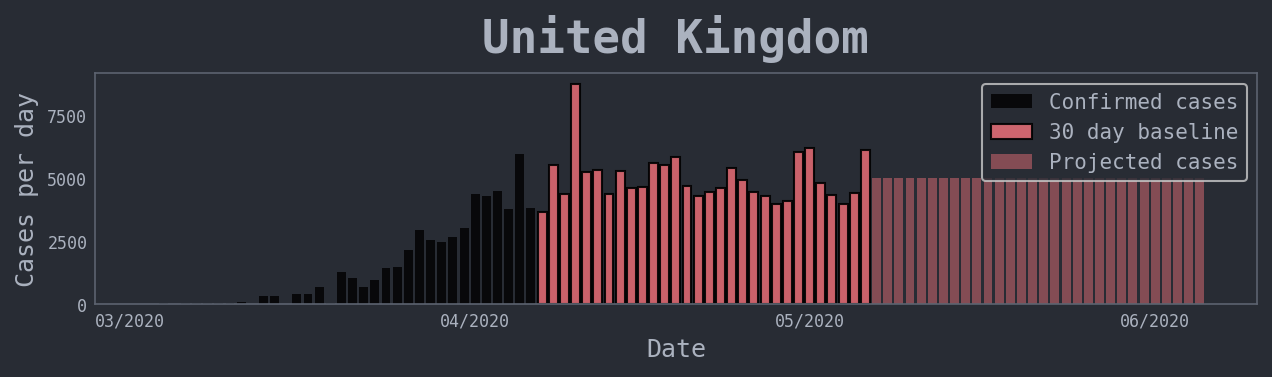

In [70]:
#hide_input
ignore = [] #["China", "Switzerland"]
for i, str_country in enumerate(countries):
    print(f"{str_country}")
    df_cases_country = dff2[dff2['country']==str_country]      

    fig, axs = plt.subplots(1, 1, figsize=(10, 2), dpi=150)
    axs.set_title(f"{str_country}", fontsize=22, fontweight="bold")
    
    axs.bar(df_cases_country.index, df_cases_country.new_confirmed, lw=4, label=f"Confirmed cases", color='k', alpha=0.8)
    
    fit_cases = df_cases_country.iloc[-MEAN_CASES_DAYS:]
    axs.bar(fit_cases.index, fit_cases.new_confirmed, lw=1, edgecolor='k', label=f"{MEAN_CASES_DAYS} day baseline", color='C0', alpha=0.9)
    
    
    axs.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every x months
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y')) 
    
    days_to_go = 30
    projected_cases_per_day = int(new_cases_mean_list[i])
    last_date = df_cases_country.iloc[[-1]].index + datetime.timedelta(days=1)
    future_cases = pd.DataFrame(index=pd.date_range(last_date[0], periods=int(days_to_go), freq='D'), columns=['new_confirmed'])
    future_cases['new_confirmed'] = projected_cases_per_day


    axs.bar(future_cases.index, future_cases.new_confirmed, lw=4, color='C0', label=f"Projected cases", alpha=0.5)


    axs.legend(loc=1, fontsize=10)

    plt.xlabel(f"Date", fontsize=12)
    axs.xaxis.set_tick_params(width=1)
    axs.yaxis.set_tick_params(width=1)
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    axs.set_ylabel(f"Cases per day", fontsize=12)
    plt.show()
